#### **Problem Statement**

1. Bagaimana perbandingan limit balance menurut level pendidikan dari masing-masing nasabah?
2. Bagaimana perbandingan limit balance menurut usia?
3. Credit card paling banyak digunakan oleh kelompok usia mana saja?

- -----

#### **Import Library**

In [191]:
#library untuk memanggil dataset dan manipulasi data
import pandas as pd
import numpy as np

#library untuk visualisasi data
import matplotlib.pyplot as plt
import seaborn as sns

#Library untuk feature engineering
from scipy.stats import kendalltau, spearmanr
from sklearn.model_selection import train_test_split
from feature_engine.outliers import Winsorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, recall_score, precision_score

#Library untuk menyimpan model
import pickle
import json

#### **Data Loading**

Dataset yang digunakan berasal dari Google BigQuery. Dataset diekstrak dan kemudian kita simpan ke dalam bentuk csv. Berikut adalah code query yang digunakan untuk melakukan ekstrak dataset.

```
SELECT 
  limit_balance,
  CAST(sex AS INTEGER) AS sex,
  CAST(education_level AS INTEGER) AS education_level,
  CAST(marital_status AS INTEGER) AS marital_status,
  age,
  pay_0,
  pay_2,
  pay_3,
  pay_4,
  CAST(pay_5 AS FLOAT64) AS pay_5,
  CAST(pay_6 AS FLOAT64) AS pay_6,
  bill_amt_1,
  bill_amt_2,
  bill_amt_3,
  bill_amt_4,
  bill_amt_5,
  bill_amt_6,
  pay_amt_1,
  pay_amt_2,
  pay_amt_3,
  pay_amt_4,
  pay_amt_5,
  pay_amt_6,
  CAST(default_payment_next_month AS INTEGER) AS default_payment_next_month
FROM bigquery-public-data.ml_datasets.credit_card_default
LIMIT 35982
```

In [226]:
#Memanggil dataset
data = pd.read_csv('P1G5_Set_1_Christopher.csv')
data.head(10)

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
0,80000.0,1,6,1,54.0,0.0,0.0,0.0,0.0,0.0,...,29296.0,26210.0,17643.0,2545.0,2208.0,1336.0,2232.0,542.0,348.0,1
1,200000.0,1,4,1,49.0,0.0,0.0,0.0,0.0,0.0,...,50146.0,50235.0,48984.0,1689.0,2164.0,2500.0,3480.0,2500.0,3000.0,0
2,20000.0,2,6,2,22.0,0.0,0.0,0.0,0.0,0.0,...,1434.0,500.0,0.0,4641.0,1019.0,900.0,0.0,1500.0,0.0,1
3,260000.0,2,4,2,33.0,0.0,0.0,0.0,0.0,0.0,...,27821.0,30767.0,29890.0,5000.0,5000.0,1137.0,5000.0,1085.0,5000.0,0
4,150000.0,1,4,2,32.0,0.0,0.0,0.0,-1.0,0.0,...,150464.0,143375.0,146411.0,4019.0,146896.0,157436.0,4600.0,4709.0,5600.0,0
5,300000.0,2,4,2,32.0,0.0,0.0,0.0,0.0,0.0,...,65150.0,-450.0,700.0,15235.0,1491.0,1303.0,0.0,2000.0,1400.0,0
6,130000.0,1,1,1,45.0,0.0,0.0,0.0,0.0,0.0,...,62377.0,63832.0,65099.0,2886.0,2908.0,2129.0,2354.0,2366.0,2291.0,0
7,200000.0,1,1,1,58.0,0.0,0.0,0.0,0.0,0.0,...,124647.0,126921.0,129167.0,7822.0,4417.0,4446.0,4597.0,4677.0,4698.0,0
8,500000.0,1,1,1,39.0,0.0,0.0,0.0,0.0,0.0,...,174500.0,137406.0,204975.0,54209.0,4607.0,4603.0,5224.0,207440.0,7509.0,0
9,230000.0,1,1,1,48.0,0.0,0.0,0.0,0.0,0.0,...,105508.0,108101.0,110094.0,7000.0,6607.0,3773.0,4290.0,4164.0,2000.0,0


In [227]:
data.tail(10)

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
2955,360000.0,2,2,2,26.0,-1.0,-1.0,-1.0,-1.0,-2.0,...,0.0,0.0,0.0,463.0,2500.0,0.0,0.0,0.0,0.0,0
2956,100000.0,1,3,1,40.0,0.0,0.0,-1.0,-1.0,-2.0,...,0.0,0.0,0.0,2000.0,2377.0,40000.0,0.0,0.0,0.0,0
2957,30000.0,2,3,1,48.0,1.0,-1.0,-1.0,-2.0,-2.0,...,0.0,0.0,0.0,200.0,0.0,0.0,0.0,0.0,0.0,0
2958,80000.0,2,3,1,39.0,-1.0,-1.0,-1.0,-1.0,-2.0,...,0.0,0.0,5000.0,5000.0,5000.0,0.0,5000.0,5000.0,470.0,0
2959,20000.0,1,3,2,26.0,-1.0,-1.0,-1.0,-2.0,-2.0,...,0.0,0.0,0.0,1560.0,0.0,0.0,0.0,0.0,0.0,0
2960,80000.0,2,3,2,28.0,-1.0,-1.0,-1.0,-2.0,-2.0,...,0.0,0.0,0.0,2800.0,0.0,0.0,0.0,0.0,0.0,0
2961,50000.0,2,3,1,51.0,-1.0,-1.0,-1.0,-1.0,-2.0,...,0.0,0.0,0.0,300.0,5880.0,0.0,0.0,0.0,0.0,1
2962,450000.0,2,2,1,38.0,-2.0,-2.0,-2.0,-2.0,-2.0,...,390.0,390.0,390.0,390.0,780.0,390.0,390.0,390.0,390.0,1
2963,50000.0,2,2,1,44.0,-2.0,-2.0,-2.0,-2.0,-2.0,...,390.0,390.0,0.0,390.0,390.0,390.0,390.0,0.0,780.0,0
2964,290000.0,2,2,1,39.0,1.0,-2.0,-2.0,-2.0,-2.0,...,3184.0,390.0,390.0,10000.0,800.0,3184.0,390.0,390.0,6617.0,0


In [102]:
#Memuat informasi dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2965 entries, 0 to 2964
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   limit_balance               2965 non-null   float64
 1   sex                         2965 non-null   int64  
 2   education_level             2965 non-null   int64  
 3   marital_status              2965 non-null   int64  
 4   age                         2965 non-null   float64
 5   pay_0                       2965 non-null   float64
 6   pay_2                       2965 non-null   float64
 7   pay_3                       2965 non-null   float64
 8   pay_4                       2965 non-null   float64
 9   pay_5                       2965 non-null   float64
 10  pay_6                       2965 non-null   float64
 11  bill_amt_1                  2965 non-null   float64
 12  bill_amt_2                  2965 non-null   float64
 13  bill_amt_3                  2965 

Disini kolom-kolom yang digunakan pada dataset ini telah mengalami proses encoding, dimana beberapa kolom tersebut telah menjadi bentuk encoding dengan tipe data integer dan float:
1. sex memiliki value 1 untuk Male dan 2 untuk Female
2. education memiliki value 1 untuk Graduate school, 2 untuk University, 3 untuk High school, 4 untuk others, 5 dan 6 untuk unknown (bisa diasumsikan mereka tidak mengisi jenis pendidikan yang mereka tempuh).
3. marital status memiliki value 1 untuk Single, 2 untuk Maried, dan 3 untuk Others (bisa divorced dan lain-lain).
4. pay memiliki value -1 untuk lebih cepat sebulan, 0 untuk tepat waktu, 1 untuk pembayaran terlambat 1 bulan, dan seterusnya.

Dari informasi di atas kita mendapatkan bahwa dataset memiliki ukuran 2965 rows dengan 24 kolom. Dengan rincian sebagai berikut:
1. 20 Kolom memiliki tipe data `float64`.
2. 4 Kolom memiliki tipe data `int64`.


- -------

#### **Exploratory Data Analysis**

Sebelum melakukan proses EDA, pertama kita perlu melakukan copy dataset hal ini bertujuan untuk mencegah adanya perubahan pada dataset awal bila kita ingin melakukan perubahan.

In [103]:
#Melakukan copy dataset
data_eda = data.copy()
data_eda.head()

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
0,80000.0,1,6,1,54.0,0.0,0.0,0.0,0.0,0.0,...,29296.0,26210.0,17643.0,2545.0,2208.0,1336.0,2232.0,542.0,348.0,1
1,200000.0,1,4,1,49.0,0.0,0.0,0.0,0.0,0.0,...,50146.0,50235.0,48984.0,1689.0,2164.0,2500.0,3480.0,2500.0,3000.0,0
2,20000.0,2,6,2,22.0,0.0,0.0,0.0,0.0,0.0,...,1434.0,500.0,0.0,4641.0,1019.0,900.0,0.0,1500.0,0.0,1
3,260000.0,2,4,2,33.0,0.0,0.0,0.0,0.0,0.0,...,27821.0,30767.0,29890.0,5000.0,5000.0,1137.0,5000.0,1085.0,5000.0,0
4,150000.0,1,4,2,32.0,0.0,0.0,0.0,-1.0,0.0,...,150464.0,143375.0,146411.0,4019.0,146896.0,157436.0,4600.0,4709.0,5600.0,0


In [104]:
#Mengecek missing value
data_eda.isnull().sum()

limit_balance                 0
sex                           0
education_level               0
marital_status                0
age                           0
pay_0                         0
pay_2                         0
pay_3                         0
pay_4                         0
pay_5                         0
pay_6                         0
bill_amt_1                    0
bill_amt_2                    0
bill_amt_3                    0
bill_amt_4                    0
bill_amt_5                    0
bill_amt_6                    0
pay_amt_1                     0
pay_amt_2                     0
pay_amt_3                     0
pay_amt_4                     0
pay_amt_5                     0
pay_amt_6                     0
default_payment_next_month    0
dtype: int64

In [105]:
data_eda.duplicated().sum()

1

Setelah dilakukan pengecekan apabila dataset memiliki baris dan kolom yang terduplikat dan memiliki value NaN, kita mendapatakan bahwa dataset memiliki 1 data yang terduplikasi sehingga harus kita drop dan juga tidak memiliki NaN value.

In [106]:
data_eda.drop_duplicates().head()

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
0,80000.0,1,6,1,54.0,0.0,0.0,0.0,0.0,0.0,...,29296.0,26210.0,17643.0,2545.0,2208.0,1336.0,2232.0,542.0,348.0,1
1,200000.0,1,4,1,49.0,0.0,0.0,0.0,0.0,0.0,...,50146.0,50235.0,48984.0,1689.0,2164.0,2500.0,3480.0,2500.0,3000.0,0
2,20000.0,2,6,2,22.0,0.0,0.0,0.0,0.0,0.0,...,1434.0,500.0,0.0,4641.0,1019.0,900.0,0.0,1500.0,0.0,1
3,260000.0,2,4,2,33.0,0.0,0.0,0.0,0.0,0.0,...,27821.0,30767.0,29890.0,5000.0,5000.0,1137.0,5000.0,1085.0,5000.0,0
4,150000.0,1,4,2,32.0,0.0,0.0,0.0,-1.0,0.0,...,150464.0,143375.0,146411.0,4019.0,146896.0,157436.0,4600.0,4709.0,5600.0,0


Disini kita telah melakukan drop duplicates sehingga sekarang kolom memiliki ukuran 2964 rows x 24 columns.

**Perbandingan limit balance menurut level pendidikan dari masing-masing nasabah?**

In [107]:
#mencari total limit balance berdasarkan jenjang pendidikan
limit_by_education = data_eda.groupby('education_level')['limit_balance'].sum().sort_values(ascending=False).reset_index()
limit_by_education

,education_level,limit_balance
0,1,214060000.0
1,2,202950000.0
2,3,60090000.0
3,5,3730000.0
4,4,2960000.0
5,0,350000.0
6,6,250000.0


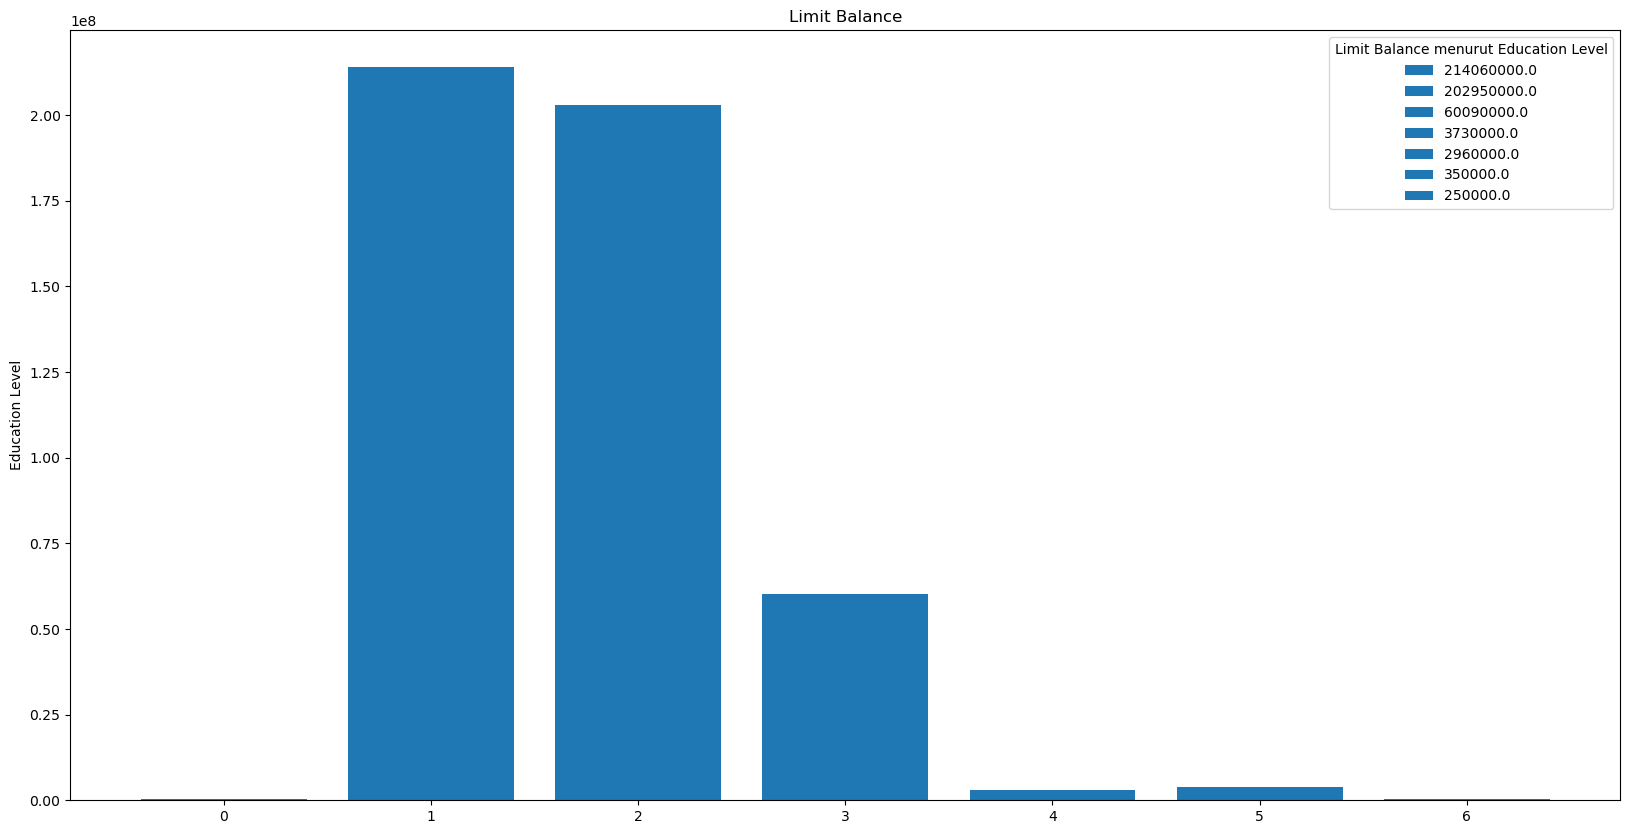

In [108]:
#Hasil visualisasi untuk limit berdasarkan jenjang pendidikan
fig, ax = plt.subplots(figsize=(20, 10))

ax.bar(limit_by_education.education_level, limit_by_education.limit_balance, label=limit_by_education.limit_balance)

ax.set_ylabel('Education Level')
ax.set_title('Limit Balance')
ax.legend(title='Limit Balance menurut Education Level')

plt.show()

Berdasarkan data di atas kita mendapatkan bahwa kelompok tingkat pendidikan Graduate School dan University mencatatkan limit balance tertinggi yaitu sebesar Rp.214.060.000 dan Rp.202.950.000 dengan kelompok tingkat pendidikan SMA dan lain-lain mencatatkan limit balance terendah.

**Perbandingan limit balance menurut usia?**

In [109]:
#Melakukan groupby dan sum untuk limit balance berdasarkan age
limit_by_age = data_eda.groupby('age')['limit_balance'].sum().sort_values(ascending=False).reset_index()
limit_by_age

,age,limit_balance
0,30.0,33680000.0
1,34.0,24190000.0
2,29.0,23960000.0
3,36.0,23760000.0
4,32.0,23280000.0
5,27.0,22850000.0
6,31.0,22160000.0
7,28.0,22100000.0
8,33.0,21860000.0
9,26.0,19400000.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


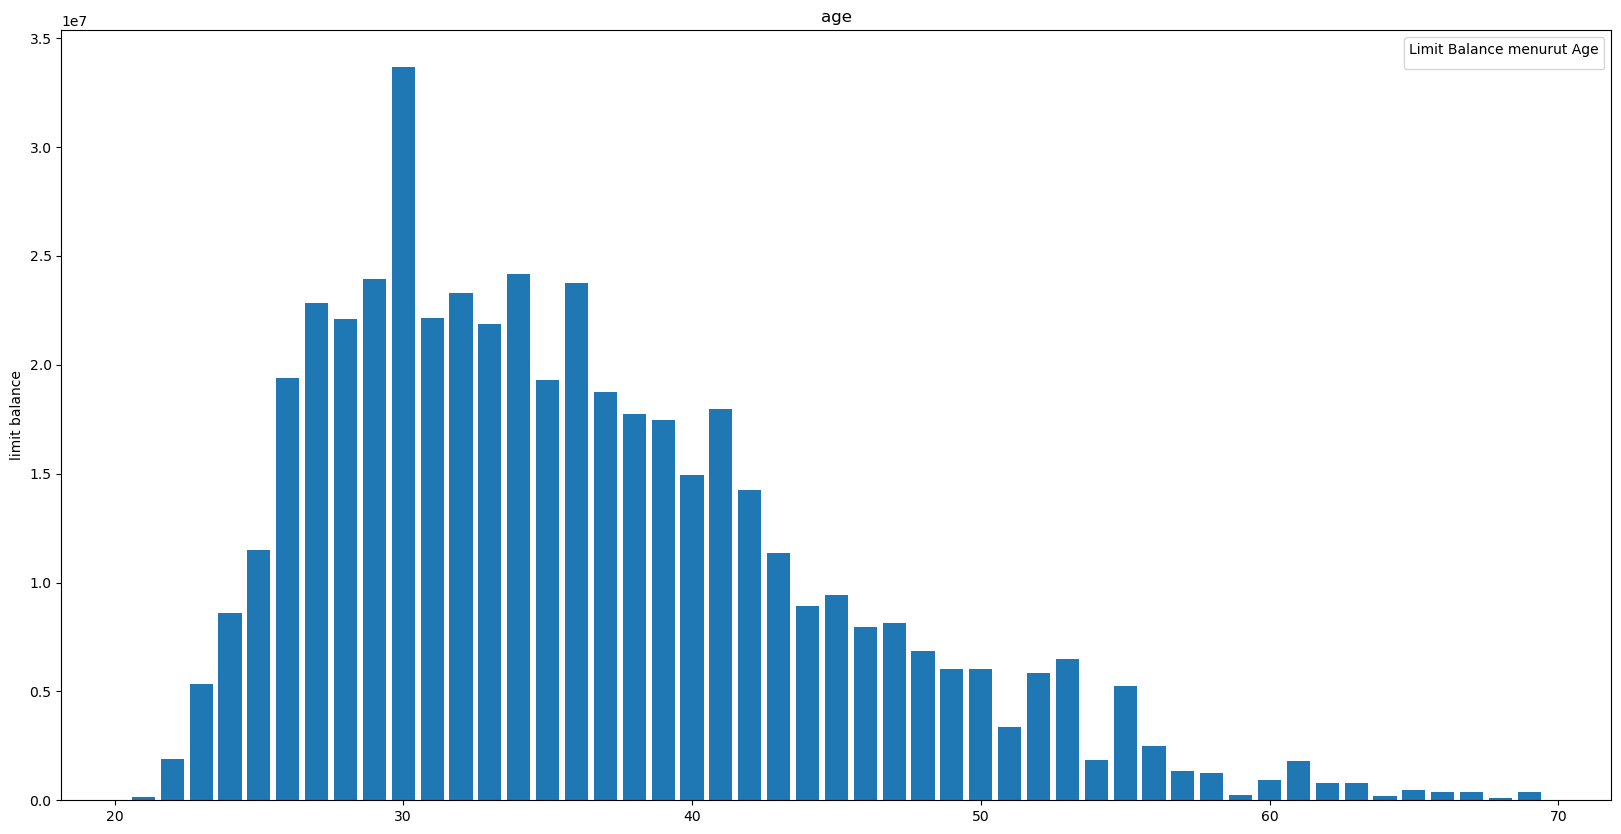

In [253]:
#Hasil visualisasi limit balance berdasarkan age
fig, ax = plt.subplots(figsize=(20, 10))

ax.bar(limit_by_age.age, limit_by_age.limit_balance)

ax.set_ylabel('limit balance')
ax.set_title('age')
ax.legend(title='Limit Balance menurut Age')

plt.show()

Dari data di atas, kita mendapatkan bahwa kelompok usia 27 hingga 36 tahun memiliki limit balance paling tinggi dengan rentang 250 juta hingga sekitar 340 juta.

**Penggunaan Credit Card menurut Usia**

<Axes: xlabel='age', ylabel='count'>

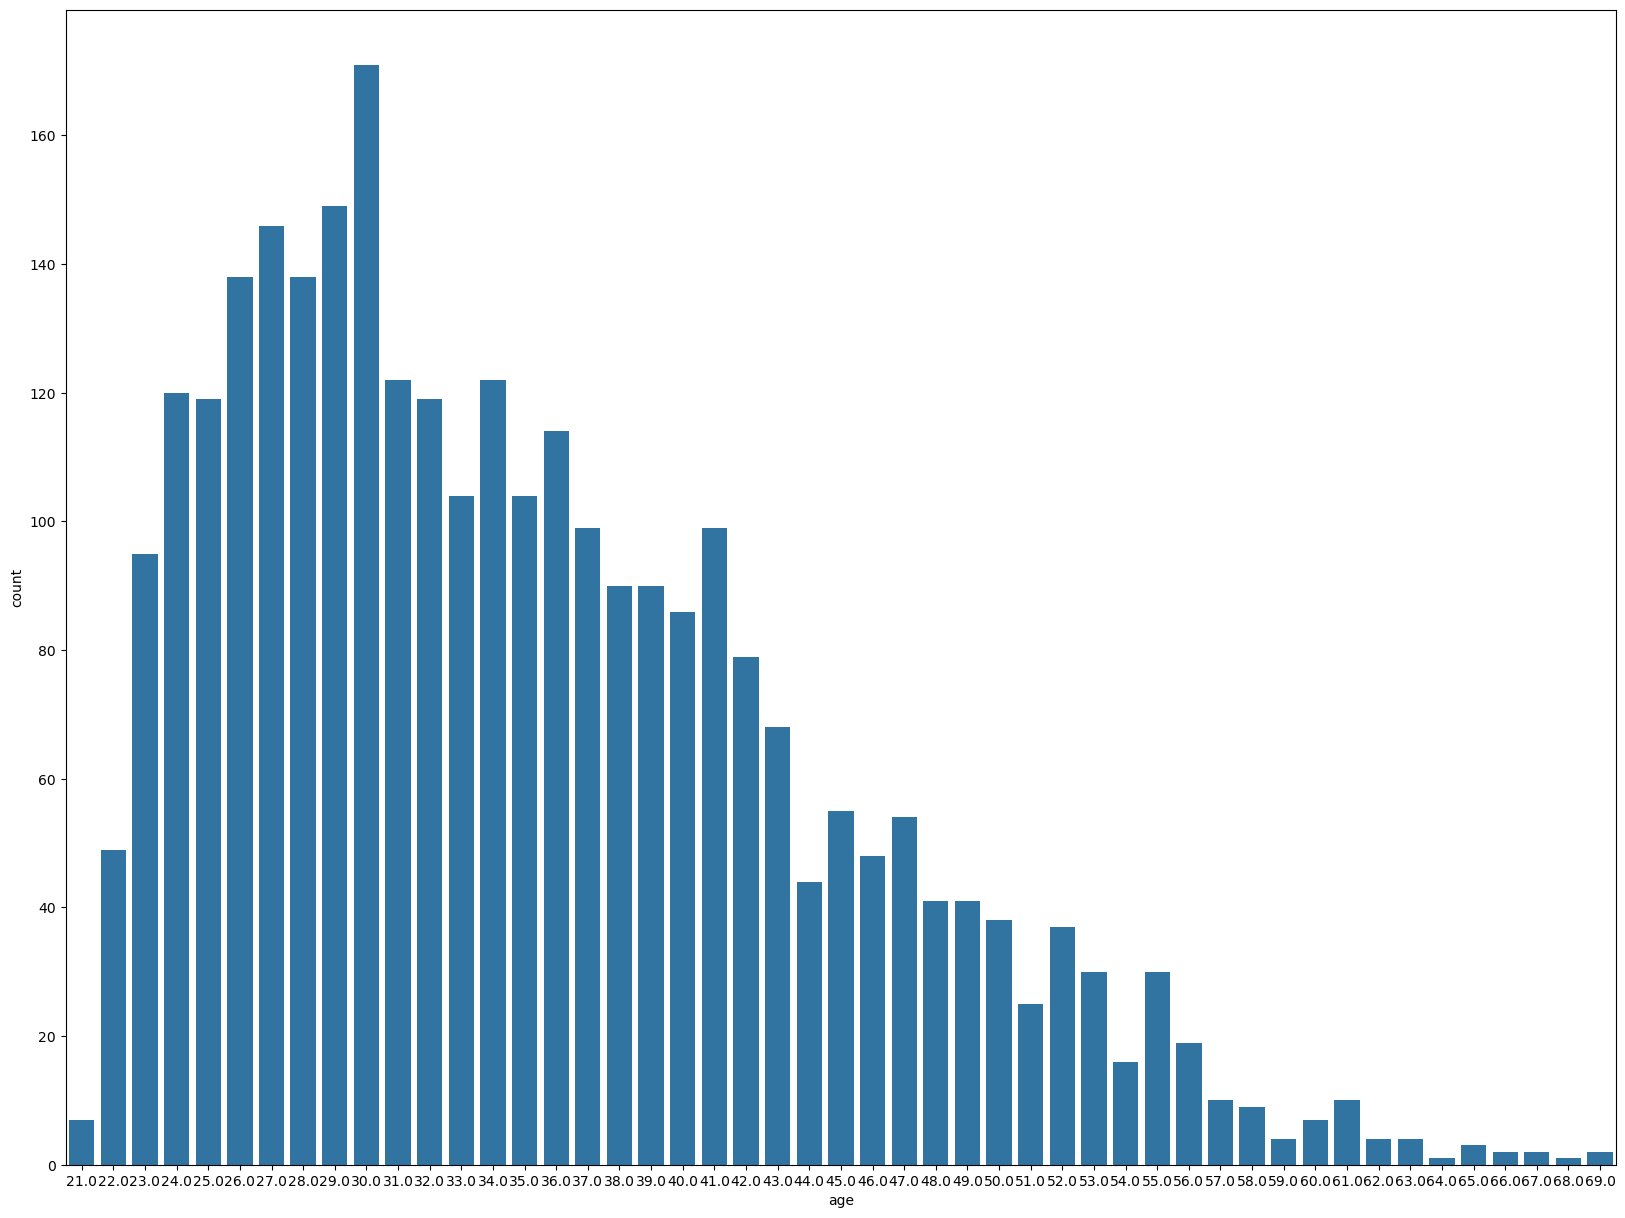

In [111]:
plt.subplots(figsize=(20, 15))
sns.countplot(data_eda, x="age")

Dari data di atas kita mendapatkan bahwa rata-rata pengguna kartu kredit dimulai dari usia sekitar 24 tahun dan memuncak di usia 30 tahun namun penurunan signifikan terjadi ketika pengguna memasuki usia menjelang 40 tahun hal ini bisa karena kebutuhan konsumtif dari konsumen mulai berkurang sehingga kebutuhan untuk menggunakan kartu kredit juga berkurang.

- ----

#### **Feature Engineering**

Melalukan copy dataset sebelum melakukan feature engineering.

In [112]:
data_feature = data_eda.copy()
data_feature.head()

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
0,80000.0,1,6,1,54.0,0.0,0.0,0.0,0.0,0.0,...,29296.0,26210.0,17643.0,2545.0,2208.0,1336.0,2232.0,542.0,348.0,1
1,200000.0,1,4,1,49.0,0.0,0.0,0.0,0.0,0.0,...,50146.0,50235.0,48984.0,1689.0,2164.0,2500.0,3480.0,2500.0,3000.0,0
2,20000.0,2,6,2,22.0,0.0,0.0,0.0,0.0,0.0,...,1434.0,500.0,0.0,4641.0,1019.0,900.0,0.0,1500.0,0.0,1
3,260000.0,2,4,2,33.0,0.0,0.0,0.0,0.0,0.0,...,27821.0,30767.0,29890.0,5000.0,5000.0,1137.0,5000.0,1085.0,5000.0,0
4,150000.0,1,4,2,32.0,0.0,0.0,0.0,-1.0,0.0,...,150464.0,143375.0,146411.0,4019.0,146896.0,157436.0,4600.0,4709.0,5600.0,0


##### **Cek Kardinalitas**

In [113]:
#Mengecek kardinalitas dataset.
def cardinality(df):
    col_name = []
    nunique = []
    unique_char = []

    for column in data_feature.columns:
        col_name.append(column)
        nunique.append(data_feature[column].nunique())
        unique_char.append(data_feature[column].unique())
    
    data_cardinality = pd.DataFrame({
        'Column Name':col_name,
        'Nunique': nunique,
        'Unique Char': unique_char
    })

    return data_cardinality

In [114]:
#Menampilkan kardinalitas dataset
pd.set_option('display.max_colwidth',None)
pd.set_option('display.max_rows', None)
cardinality(data_feature)

,Column Name,Nunique,Unique Char
0,limit_balance,59,"[80000.0, 200000.0, 20000.0, 260000.0, 150000.0, 300000.0, 130000.0, 500000.0, 230000.0, 460000.0, 780000.0, 170000.0, 320000.0, 290000.0, 240000.0, 340000.0, 360000.0, 380000.0, 180000.0, 100000.0, 90000.0, 50000.0, 160000.0, 70000.0, 280000.0, 220000.0, 30000.0, 120000.0, 10000.0, 470000.0, 310000.0, 140000.0, 60000.0, 110000.0, 430000.0, 210000.0, 490000.0, 330000.0, 250000.0, 400000.0, 370000.0, 440000.0, 700000.0, 530000.0, 390000.0, 410000.0, 270000.0, 560000.0, 40000.0, 680000.0, 480000.0, 190000.0, 350000.0, 420000.0, 510000.0, 800000.0, 450000.0, 750000.0, 620000.0]"
1,sex,2,"[1, 2]"
2,education_level,7,"[6, 4, 1, 2, 3, 5, 0]"
3,marital_status,4,"[1, 2, 3, 0]"
4,age,49,"[54.0, 49.0, 22.0, 33.0, 32.0, 45.0, 58.0, 39.0, 48.0, 34.0, 47.0, 46.0, 30.0, 35.0, 55.0, 42.0, 56.0, 31.0, 53.0, 40.0, 36.0, 51.0, 37.0, 44.0, 24.0, 38.0, 26.0, 25.0, 23.0, 27.0, 28.0, 29.0, 41.0, 63.0, 50.0, 43.0, 66.0, 61.0, 52.0, 62.0, 69.0, 21.0, 65.0, 57.0, 64.0, 67.0, 60.0, 59.0, 68.0]"
5,pay_0,11,"[0.0, 2.0, 1.0, -1.0, -2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]"
6,pay_2,10,"[0.0, -1.0, 2.0, 3.0, -2.0, 4.0, 1.0, 5.0, 6.0, 7.0]"
7,pay_3,9,"[0.0, 2.0, -2.0, 3.0, -1.0, 4.0, 5.0, 6.0, 7.0]"
8,pay_4,10,"[0.0, -1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, -2.0]"
9,pay_5,9,"[0.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, -1.0, -2.0]"


Berdasarkan value-value yang didapatkan maka kita mendapatkan tipe data untuk pembagian ketika melakukan proses Outlier Handling:

| Nama Kolom | Tipe Kardinalitas |
| ---------- | ----------------- |
| limit_balance | Numerikal |
| sex | Nominal | 
| education level | Ordinal |
| marital status | Nominal |
| age | Numerikal |
| pay 0 - pay 6 | Ordinal |
| bill_amt_1 - bill_amt_6 | Numerikal |
| pay_amt_1 - pay_amt_6 | Numerikal |
| default_payment_next_month | Nominal |

- ---

##### **Split Data Test dan Train**

In [115]:
#Melakukan drop column yang tidak dibutuhkan dalam training data
X = data_feature.drop(columns=['default_payment_next_month'], axis=1)
y = data_feature['default_payment_next_month']

# Membagi data test dan data train
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2,
                                                    random_state=2024)

# Check the size
print(f'Train set : {X_train.shape}')
print(f'test set : {X_test.shape}')

Train set : (2372, 23)
test set : (593, 23)


Dari sini kita mendapatkan ukuran dataset train dan test sebagai berikut:
1. Train set memiliki ukuran 2372 baris dan 23 kolom.
2. Test set memiliki ukuran 593 baris dan 23 kolom.

- --

##### **Outlier Handling**

In [116]:
#Melakukan proses outlier detection
def outlier_detection(dataset):
    result = pd.DataFrame()
    col_name = []
    skew = []
    upper = []
    lower = []
    has_outliers = []
    outlier_types=[]
    outlier_handling = []

    #Memuat nama kolom
    for column in dataset.columns:
        col_name.append(column)
    
    #Mencari nilai skewness
        skewval = dataset[column].skew()
        skew.append(skewval)
    
    # Extreme Skew
        if skewval > 1 or skewval < -1:
            IQR = data[column].quantile(0.75) - data[column].quantile(0.25)
            lower_boundary = data[column].quantile(0.25) - (IQR * 3)
            upper_boundary = data[column].quantile(0.75) + (IQR * 3)
            outlier_types.append('Extreme')
            outlier_handling.append('IQR')

        # Middle skewed
        elif skewval >= 0.5 or skewval <= -0.5:
            IQR = data[column].quantile(0.75) - data[column].quantile(0.25)
            lower_boundary = data[column].quantile(0.25) - (IQR * 1.5)
            upper_boundary = data[column].quantile(0.75) + (IQR * 1.5)
            outlier_types.append('Medium')
            outlier_handling.append('Quantile')
        # Normal distribusi
        else:
            std = data[column].std()
            lower_boundary = data[column].mean() - (std * 3)
            upper_boundary = data[column].mean() + (std * 3)
            outlier_types.append('Normal')
            outlier_handling.append('Gaussian')
        # AMenambahkan ke kolom upper dan lower
        upper.append(upper_boundary)
        lower.append(lower_boundary)
        
        # Chek apakah ada outlier
        outliers = (data[column] < lower_boundary) | (data[column] > upper_boundary)
        has_outliers.append(any(outliers))

    # Menambahkan data ke dataframe
    result['columns'] = col_name
    result['skewness'] = skew
    result['upper boundary'] = upper
    result['lower boundary'] = lower
    result['has outliers'] = has_outliers
    result['handling'] = outlier_handling

    return result

# Mengecek dataset numerical
outlier_data = outlier_detection(X_train)
outlier_data

,columns,skewness,upper boundary,lower boundary,has outliers,handling
0,limit_balance,1.012260,770000.000000,-490000.000000,True,IQR
1,sex,-0.433355,3.072755,0.142759,False,Gaussian
2,education_level,0.896395,3.500000,-0.500000,True,Quantile
3,marital_status,-0.009060,3.126816,-0.007086,False,Gaussian
4,age,0.758378,60.500000,8.500000,True,Quantile
5,pay_0,1.066314,3.000000,-4.000000,True,IQR
6,pay_2,0.958681,1.500000,-2.500000,True,Quantile
7,pay_3,1.058773,3.000000,-4.000000,True,IQR
8,pay_4,1.127908,3.000000,-4.000000,True,IQR
9,pay_5,1.043265,3.000000,-4.000000,True,IQR


In [117]:
#Filter untuk distribusi extreme
have_outliers = outlier_data[(outlier_data['has outliers']==True)&(outlier_data['handling']=='IQR')]['columns'].tolist()+['age']

#winsor untuk normal distribusi
winsorizer_normal = Winsorizer(
    capping_method='iqr',
    tail='both',
    fold=1.5,
    variables=have_outliers,
    missing_values='ignore'
)

X_train_capped = winsorizer_normal.fit_transform(X_train)
X_test_capped = winsorizer_normal.transform(X_test)

In [118]:
#Fungsi untuk menampilkan boxplot dari outlier sebelum dan sesudah
def diagnostic_plots(df, variable):
    # ukuran diagram
    plt.figure(figsize=(16, 4))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df[variable], bins=30)
    plt.title('Histogram')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

limit_balance - Before Capping


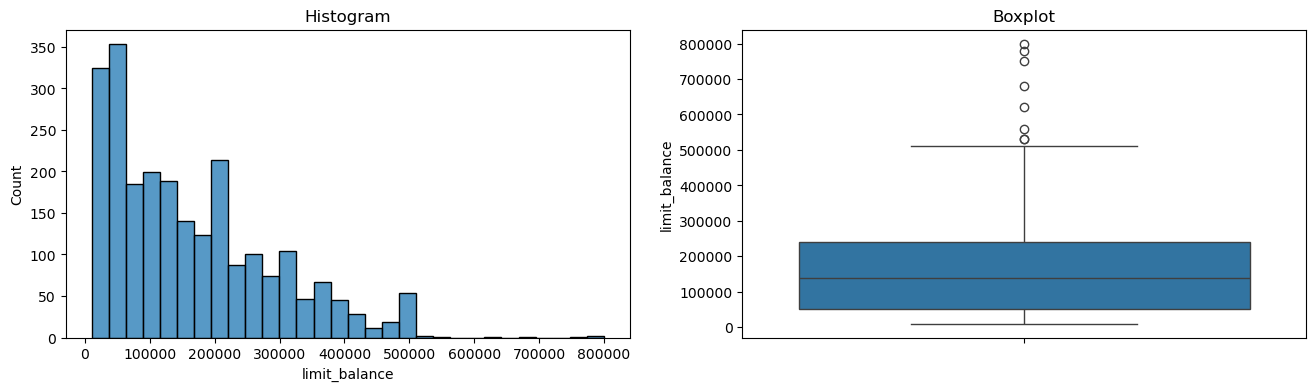


limit_balance - After Capping


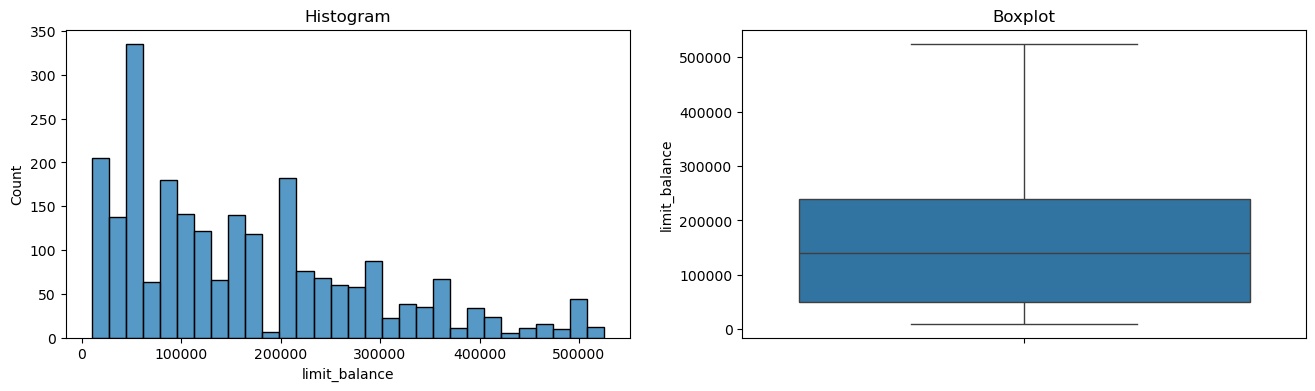

sex - Before Capping


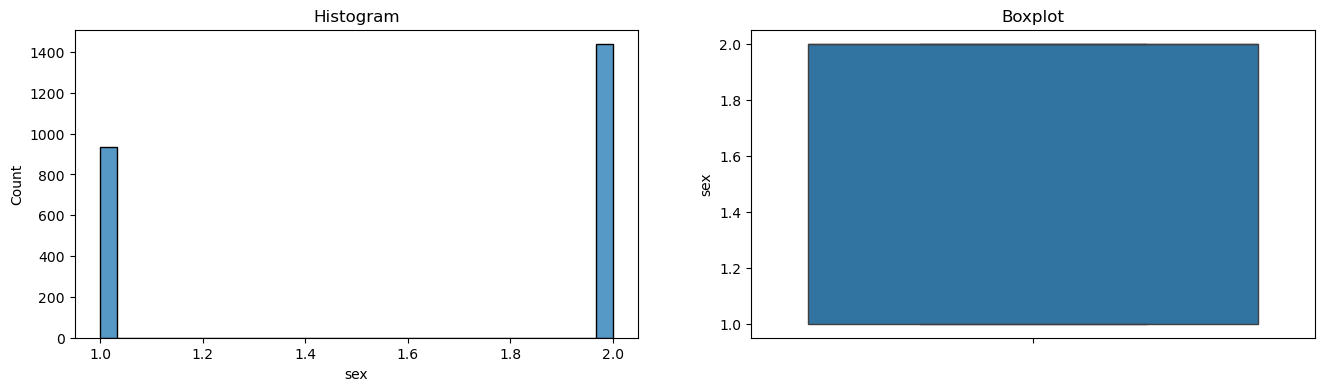


sex - After Capping


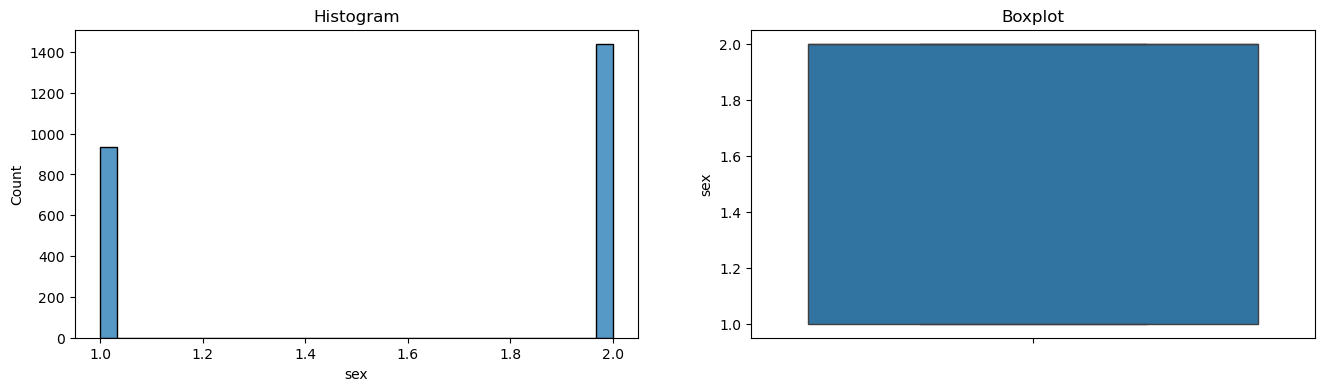

education_level - Before Capping


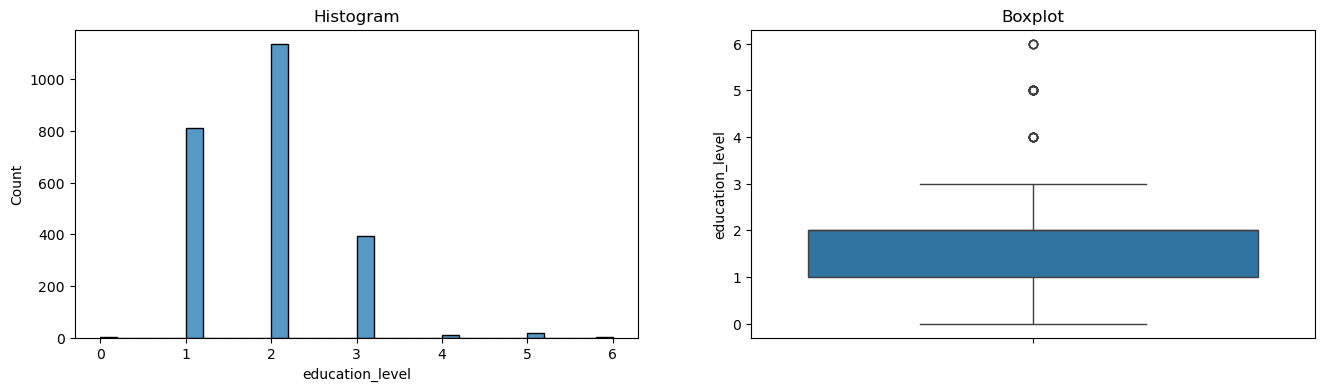


education_level - After Capping


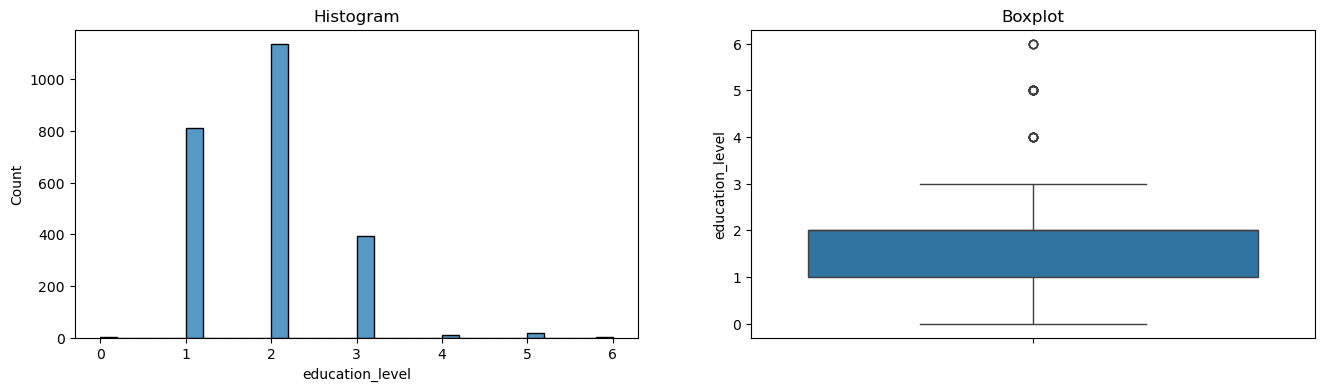

marital_status - Before Capping


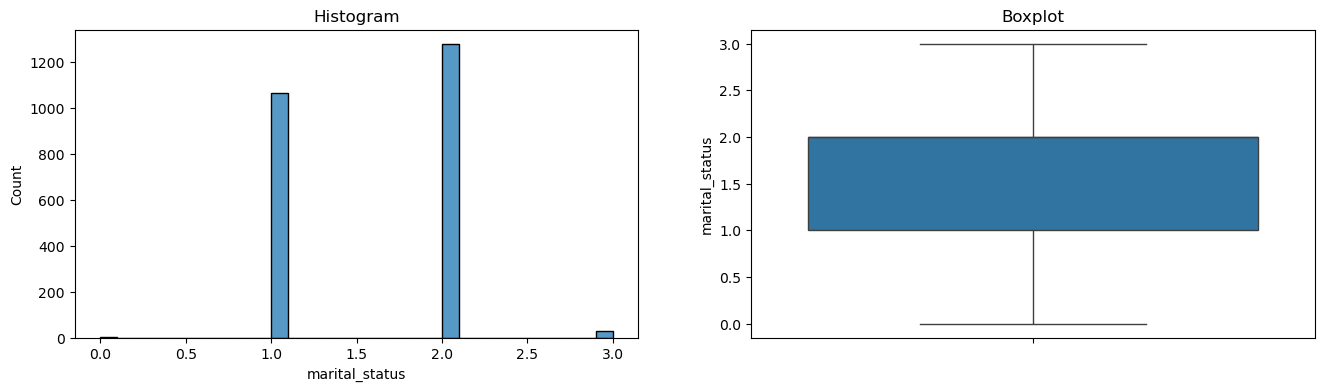


marital_status - After Capping


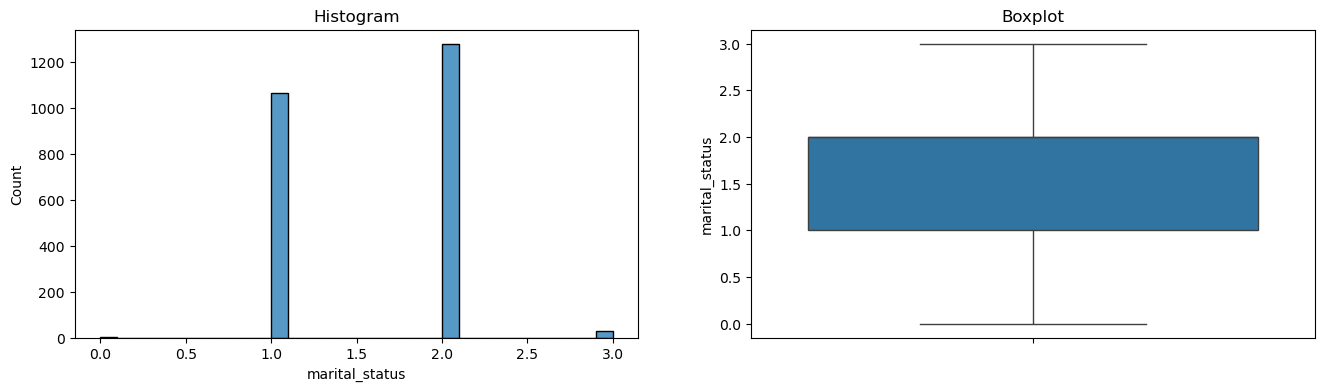

age - Before Capping


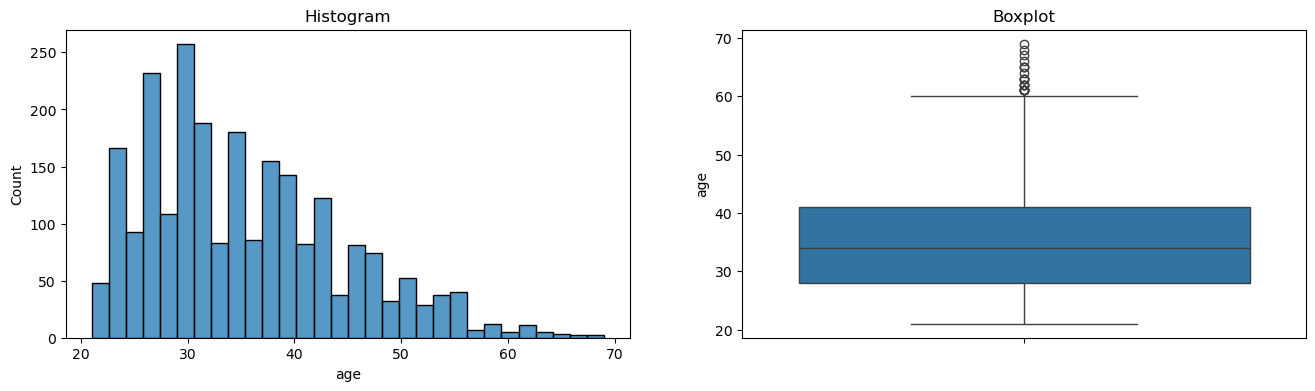


age - After Capping


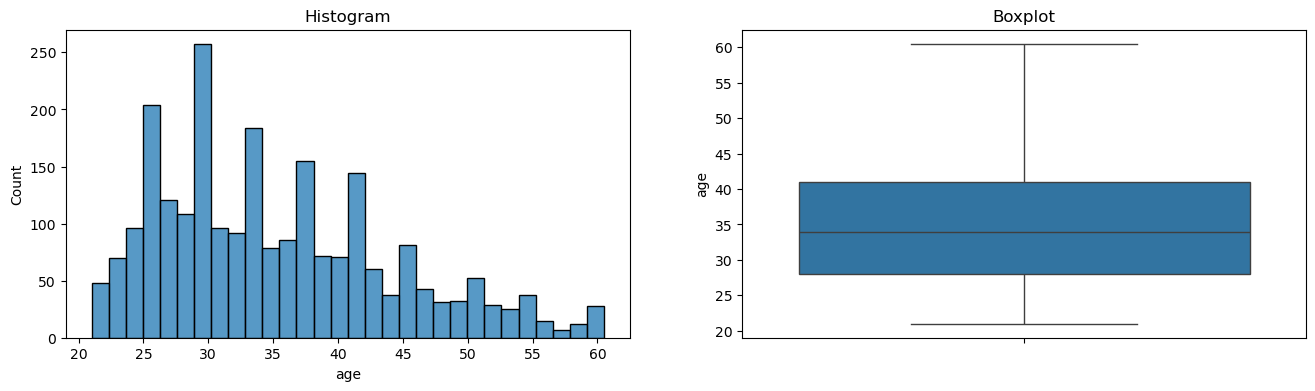

pay_0 - Before Capping


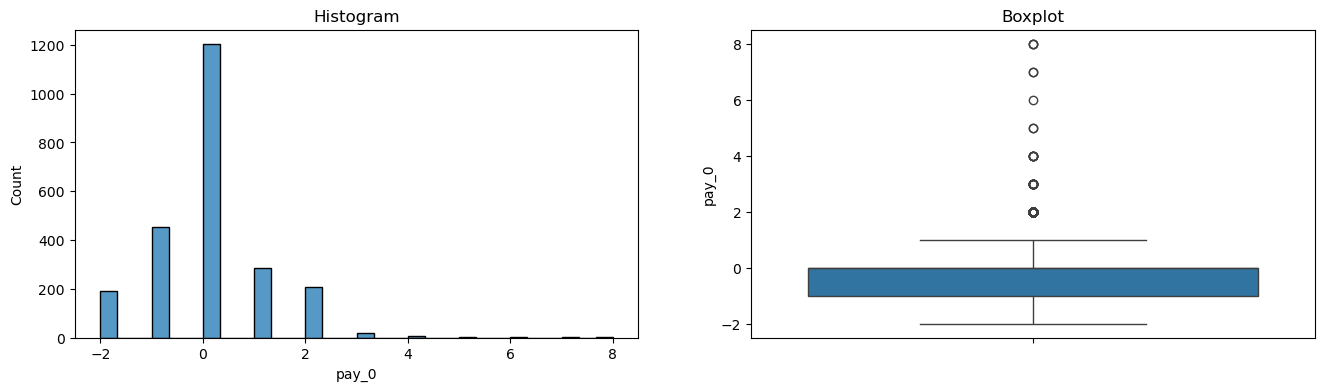


pay_0 - After Capping


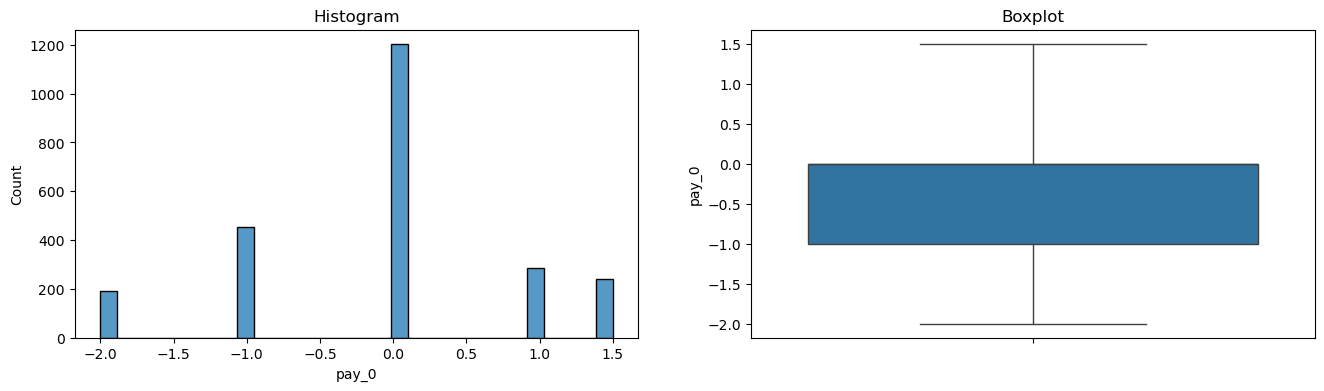

pay_2 - Before Capping


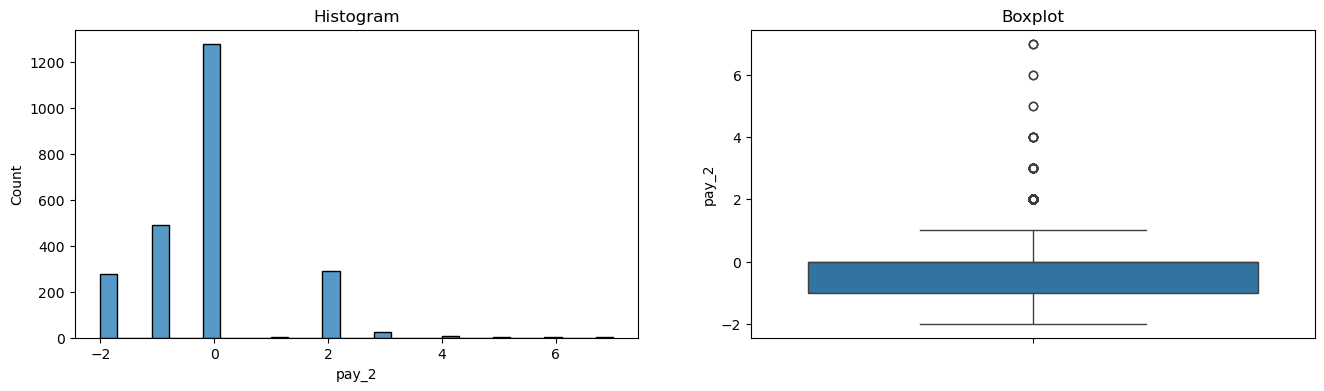


pay_2 - After Capping


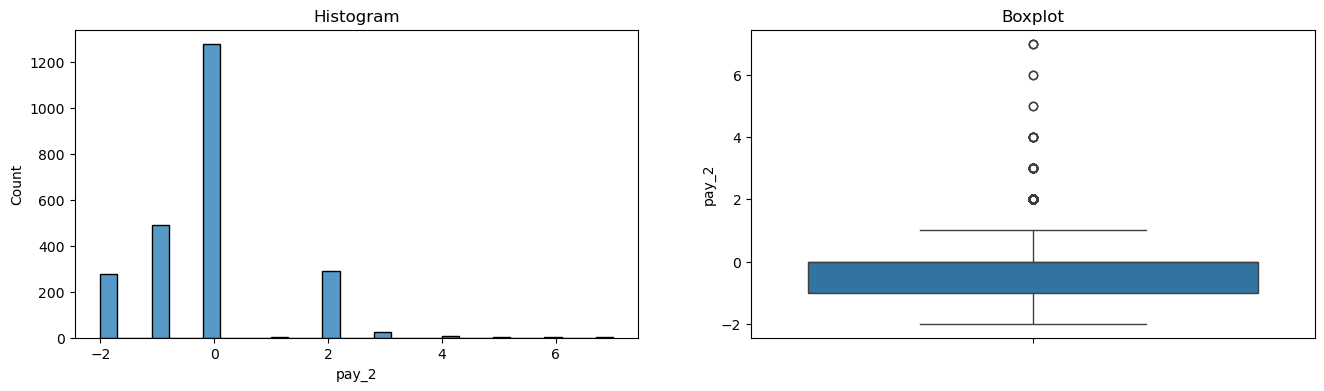

pay_3 - Before Capping


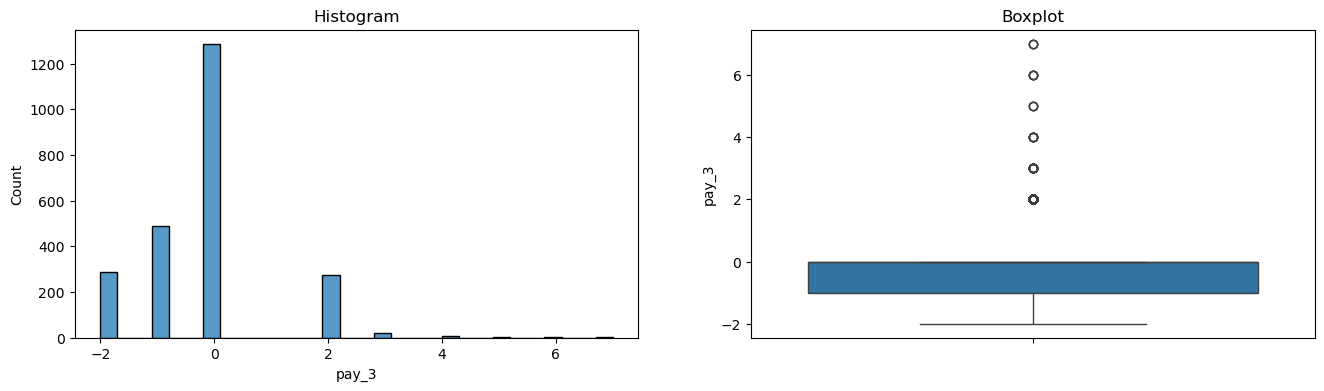


pay_3 - After Capping


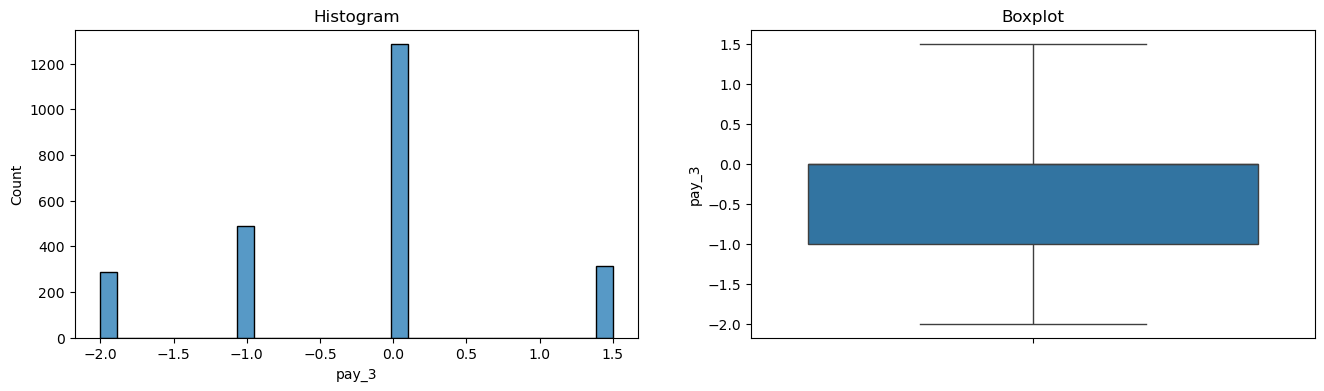

pay_4 - Before Capping


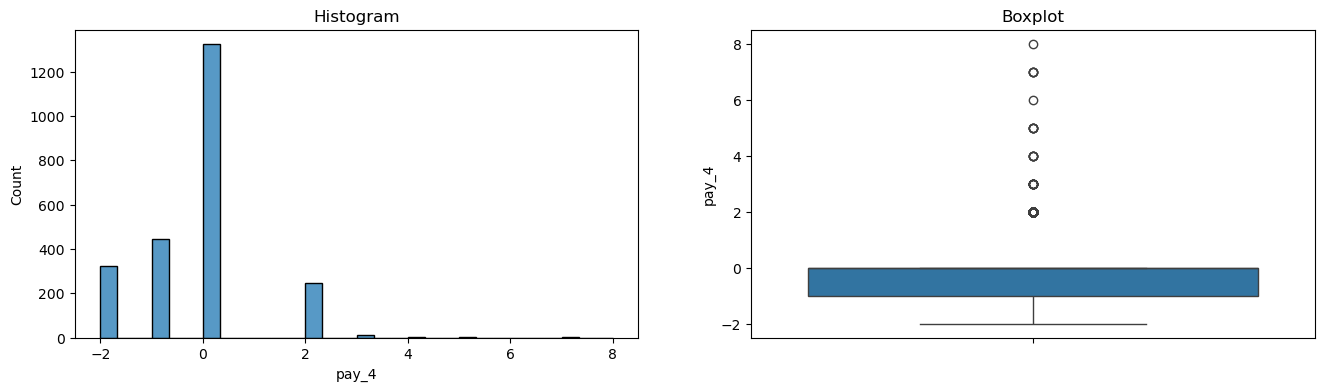


pay_4 - After Capping


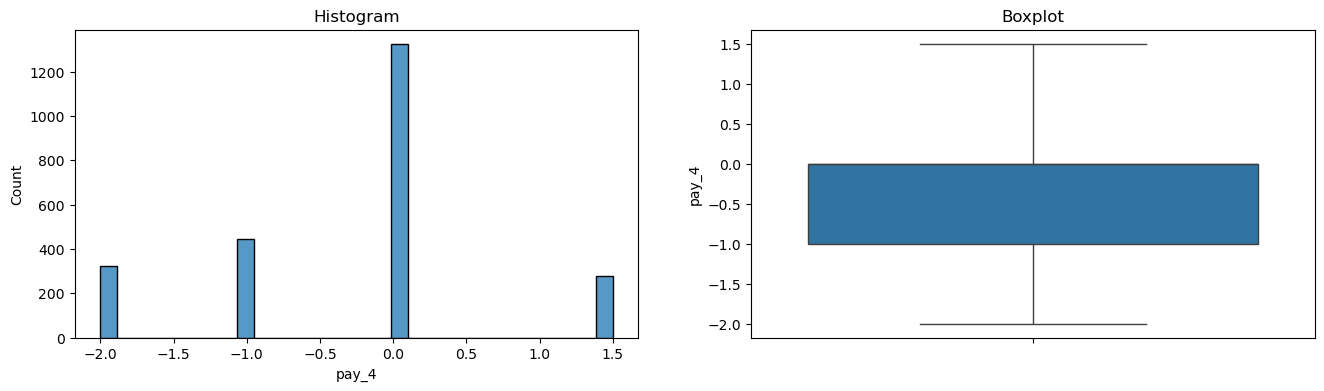

pay_5 - Before Capping


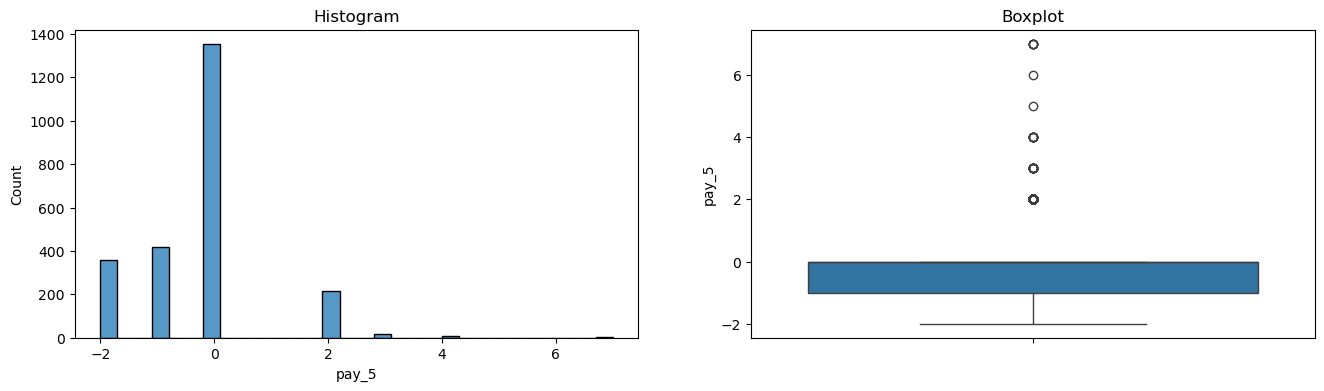


pay_5 - After Capping


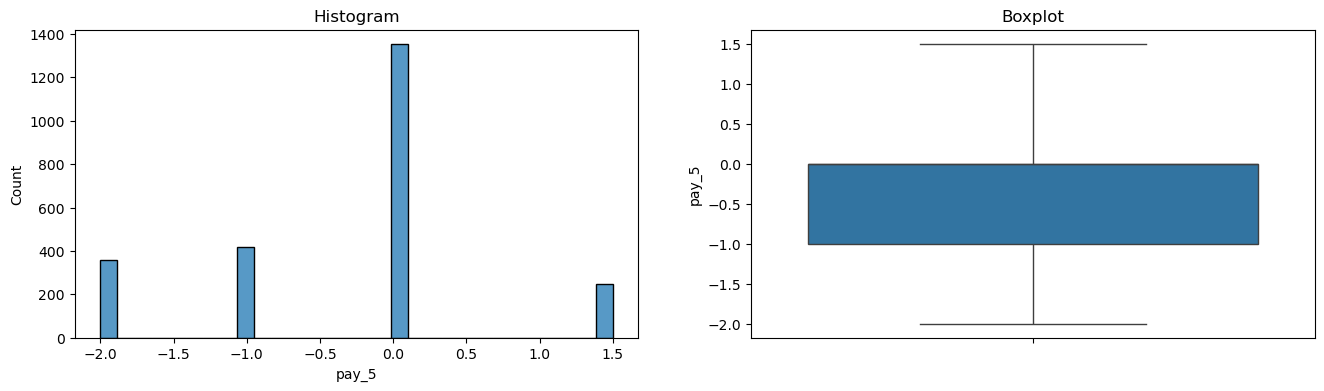

pay_6 - Before Capping


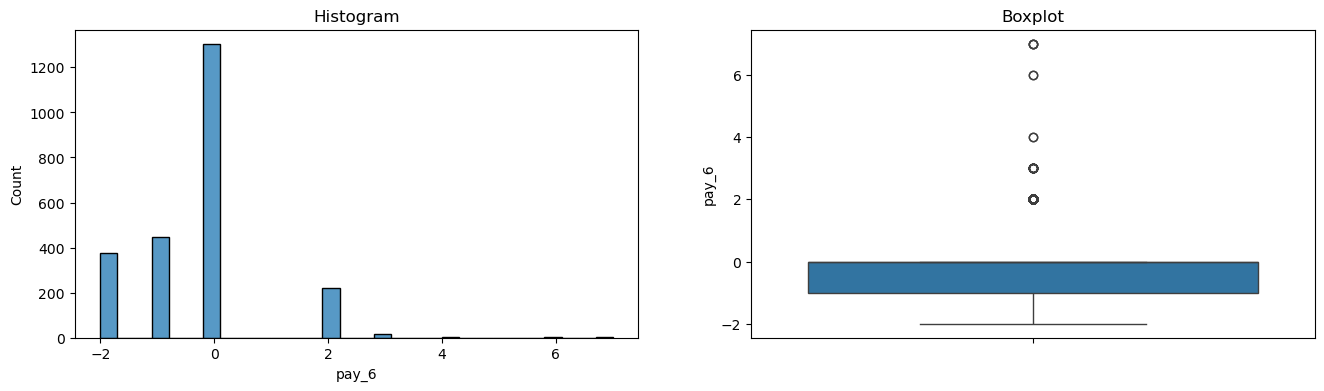


pay_6 - After Capping


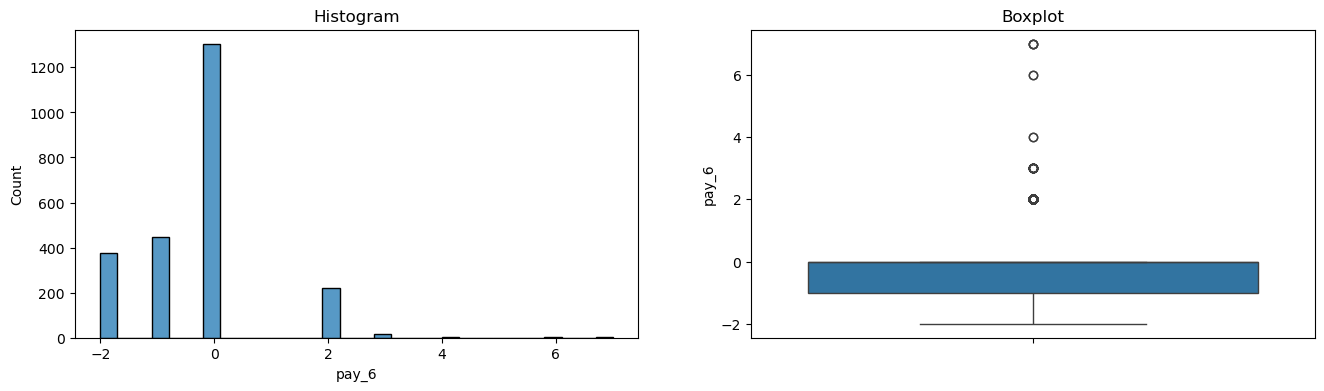

bill_amt_1 - Before Capping


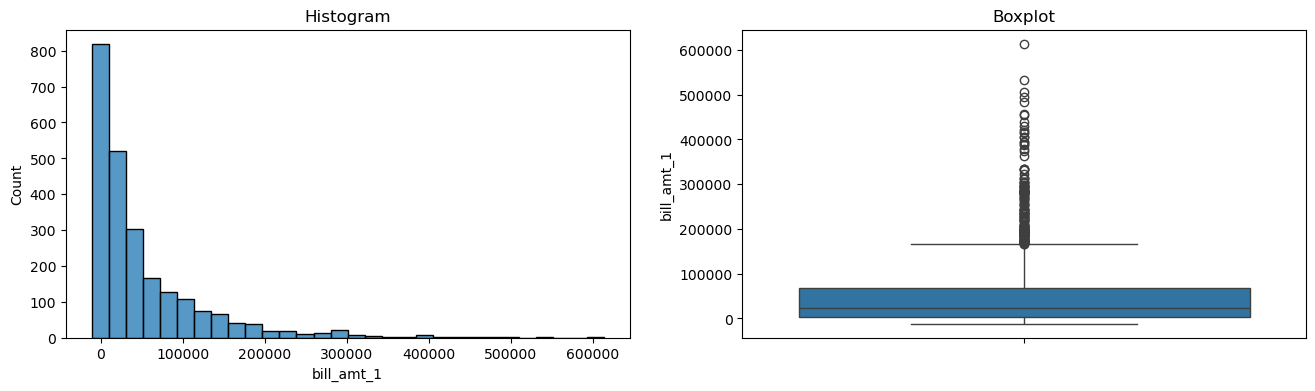


bill_amt_1 - After Capping


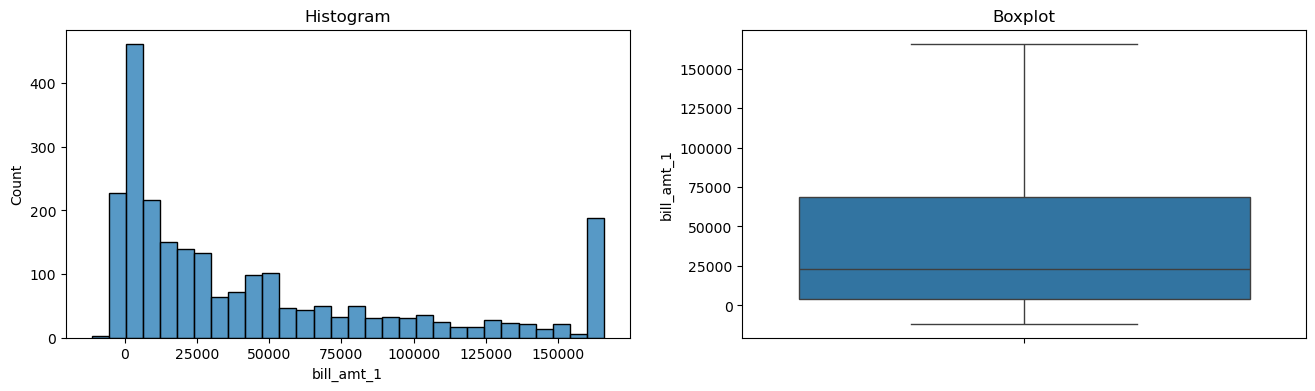

bill_amt_2 - Before Capping


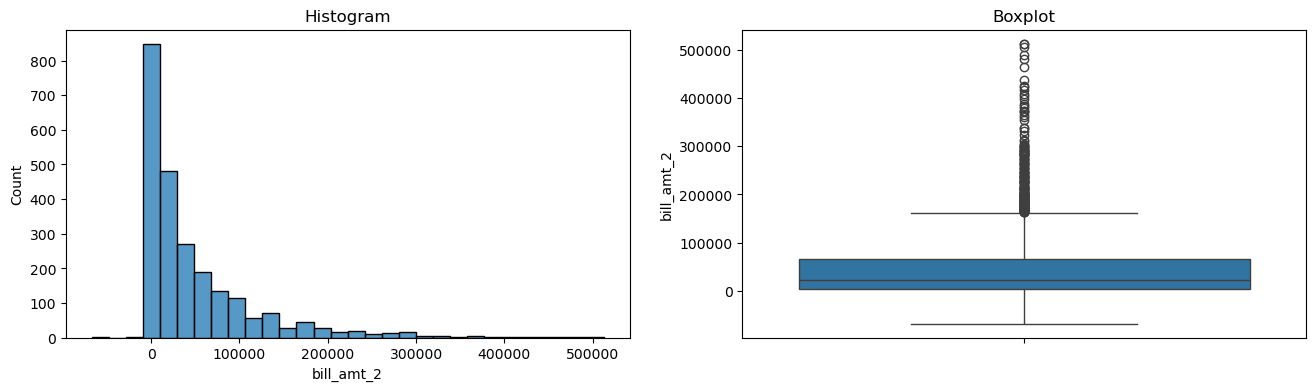


bill_amt_2 - After Capping


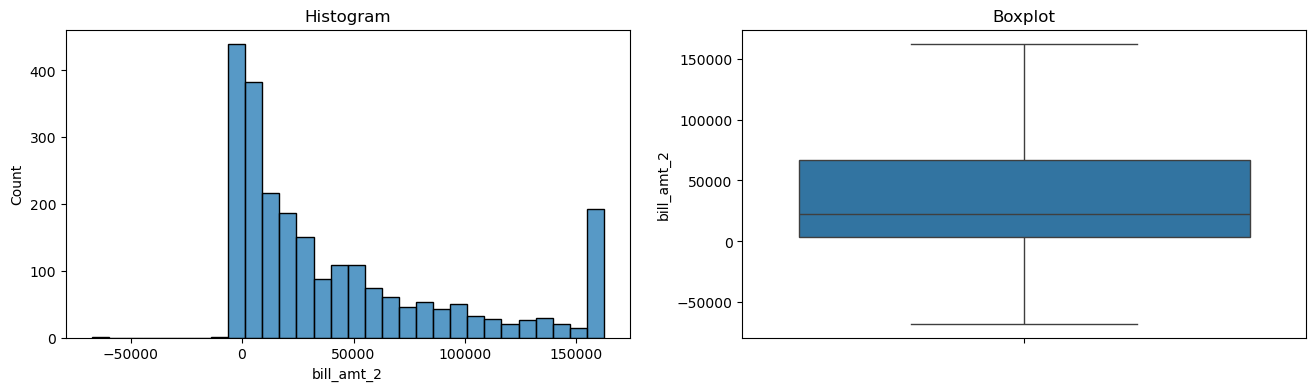

bill_amt_3 - Before Capping


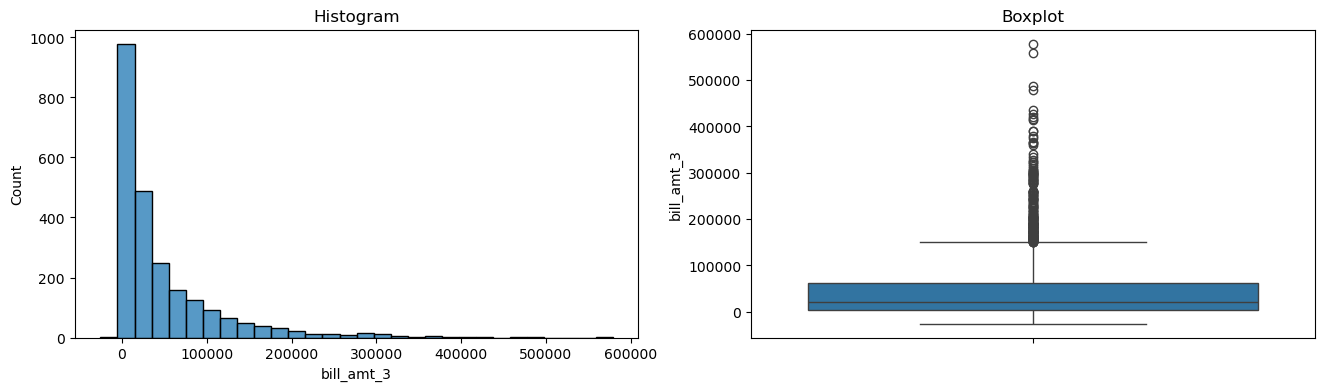


bill_amt_3 - After Capping


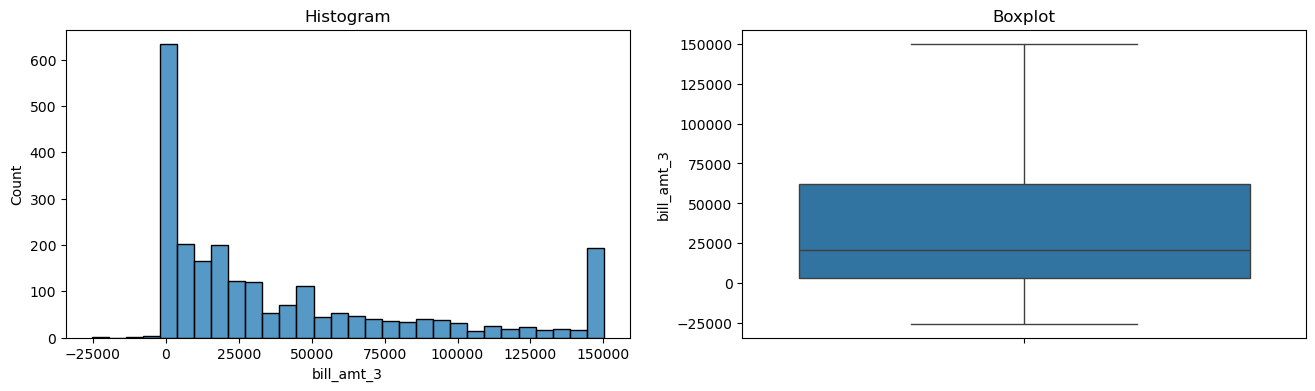

bill_amt_4 - Before Capping


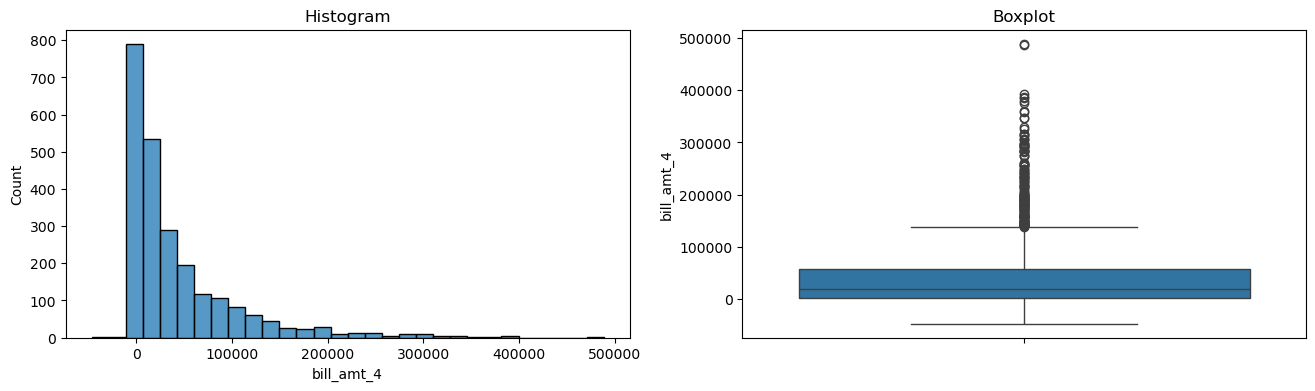


bill_amt_4 - After Capping


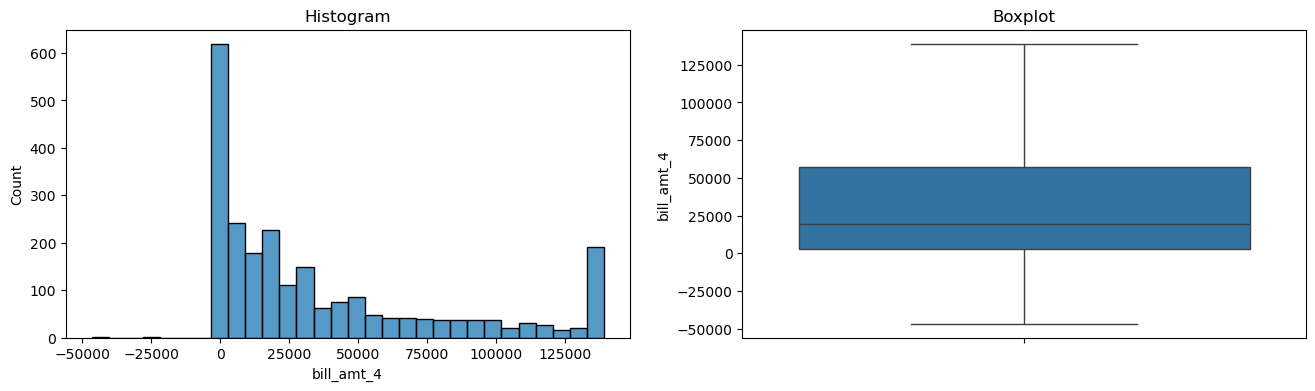

bill_amt_5 - Before Capping


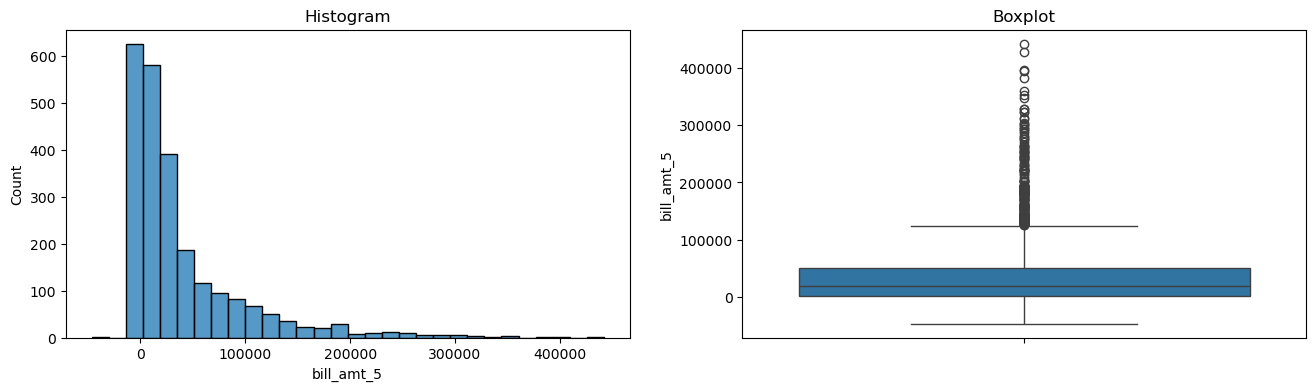


bill_amt_5 - After Capping


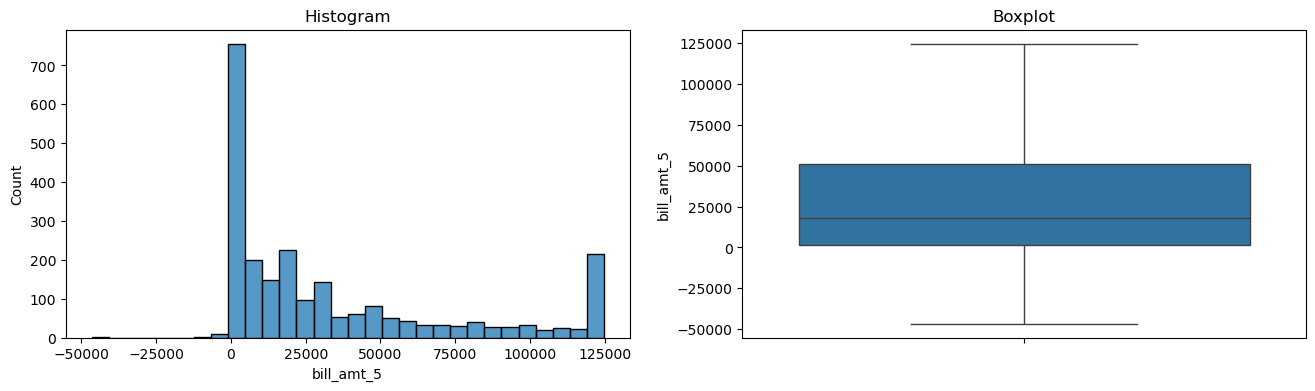

bill_amt_6 - Before Capping


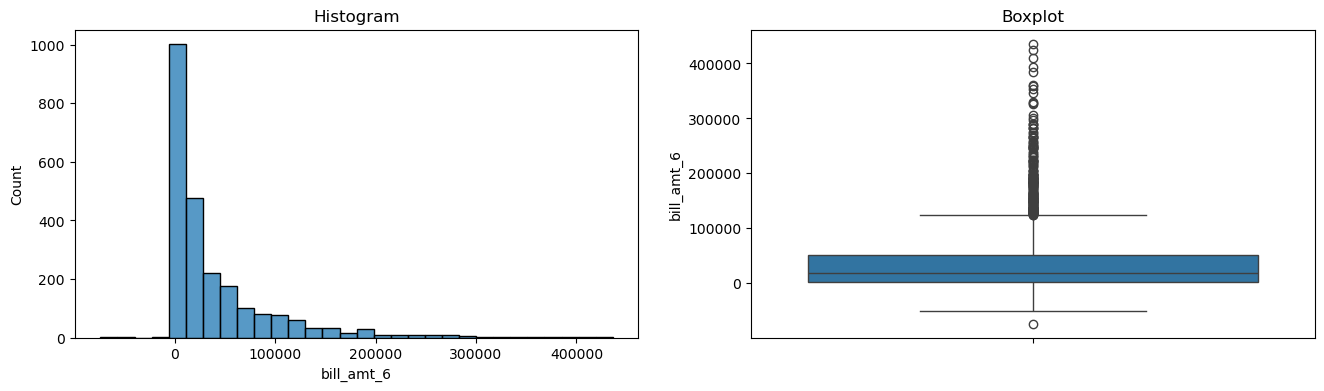


bill_amt_6 - After Capping


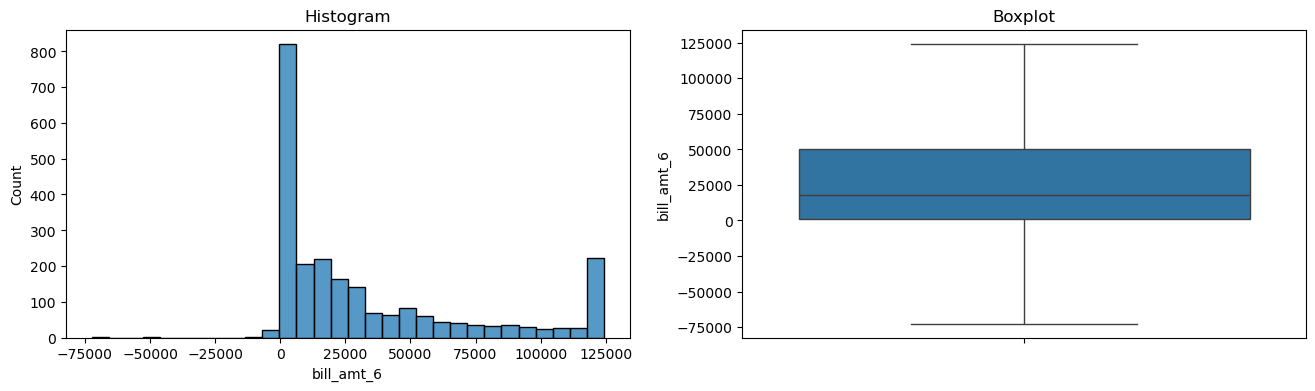

pay_amt_1 - Before Capping


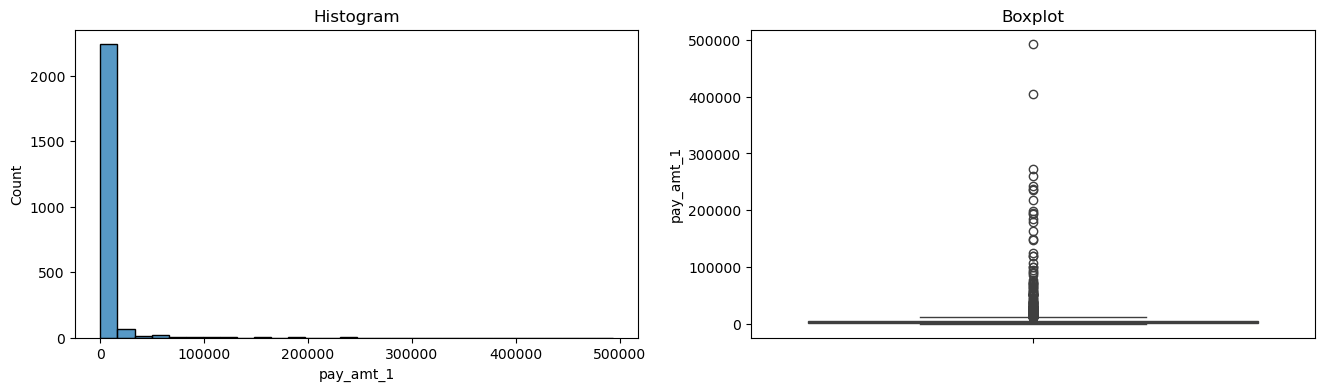


pay_amt_1 - After Capping


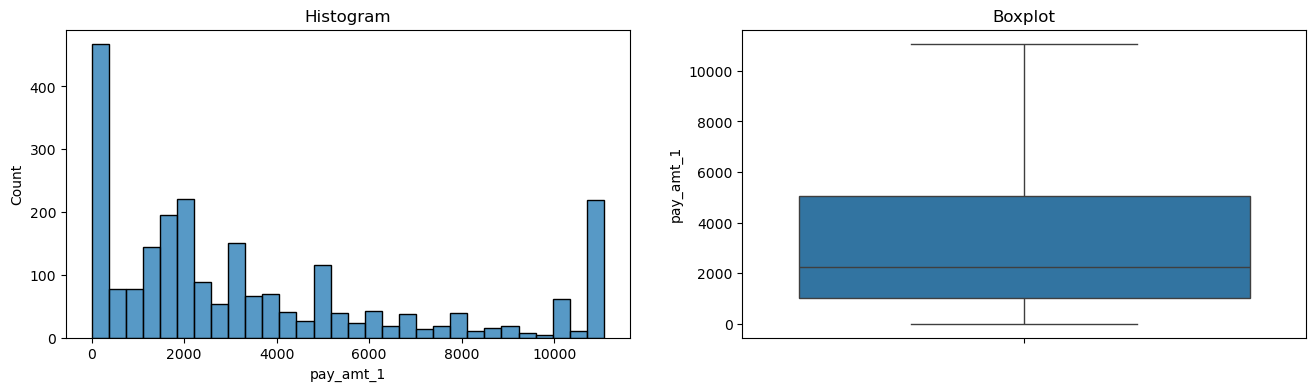

pay_amt_2 - Before Capping


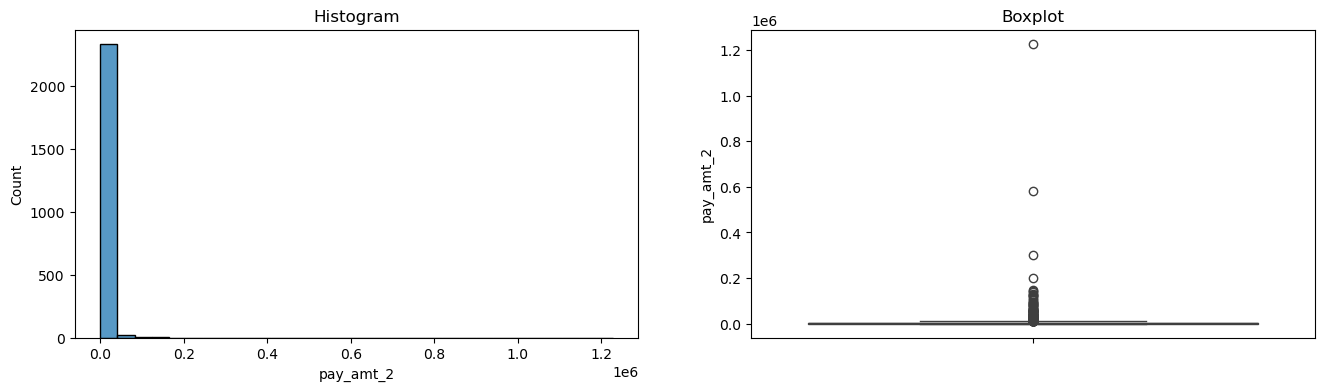


pay_amt_2 - After Capping


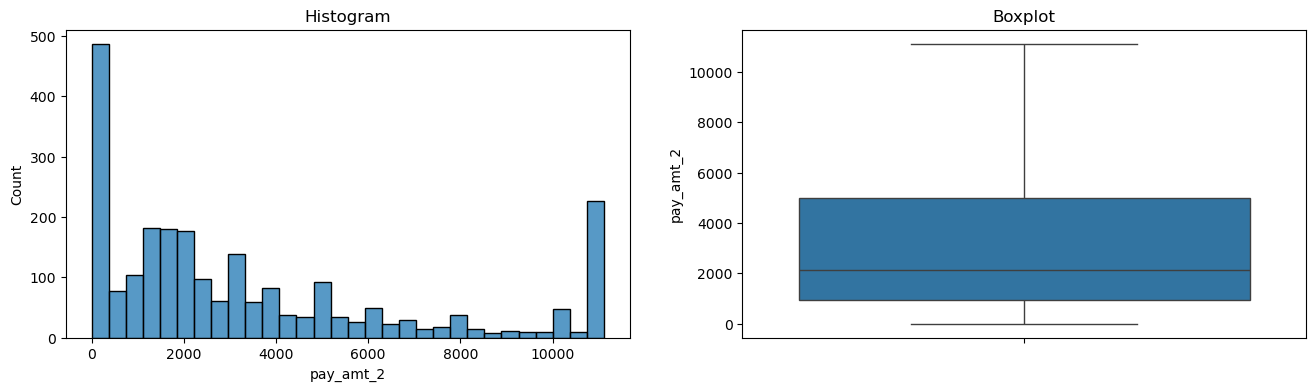

pay_amt_3 - Before Capping


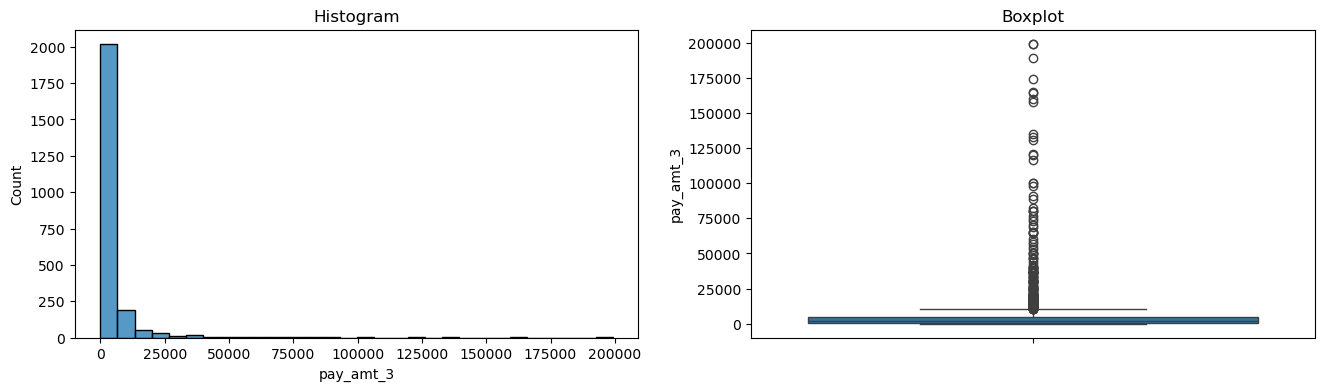


pay_amt_3 - After Capping


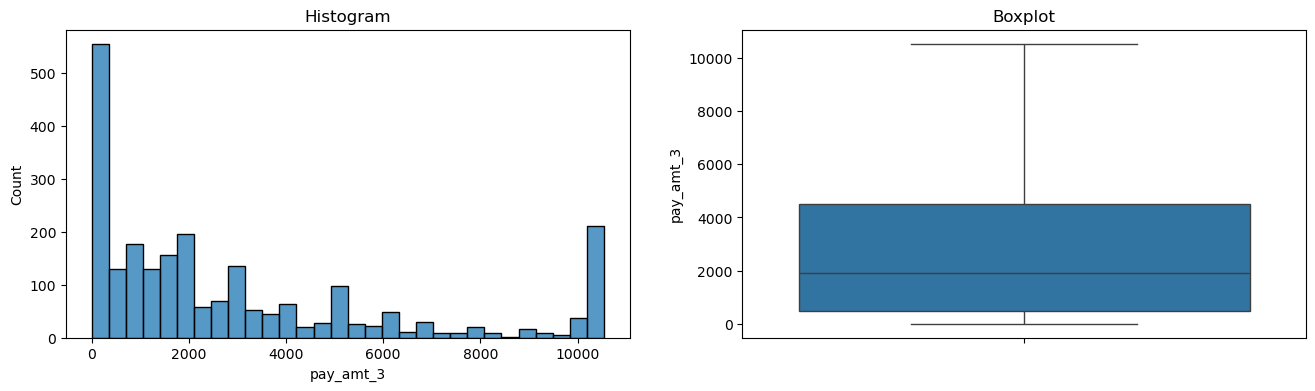

pay_amt_4 - Before Capping


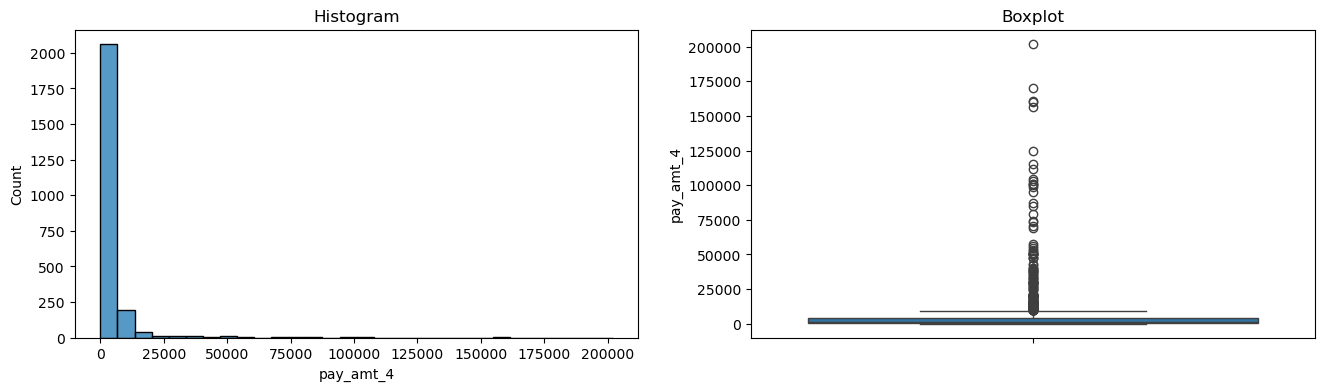


pay_amt_4 - After Capping


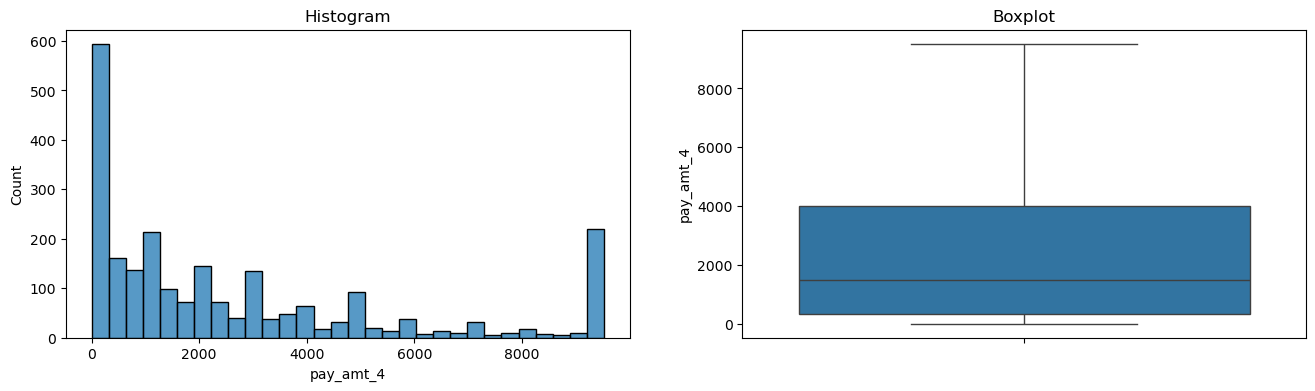

pay_amt_5 - Before Capping


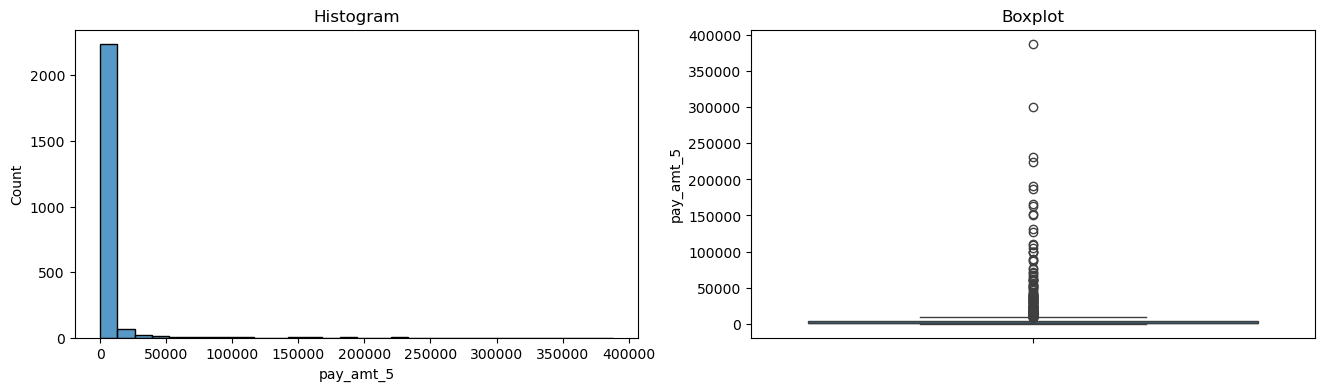


pay_amt_5 - After Capping


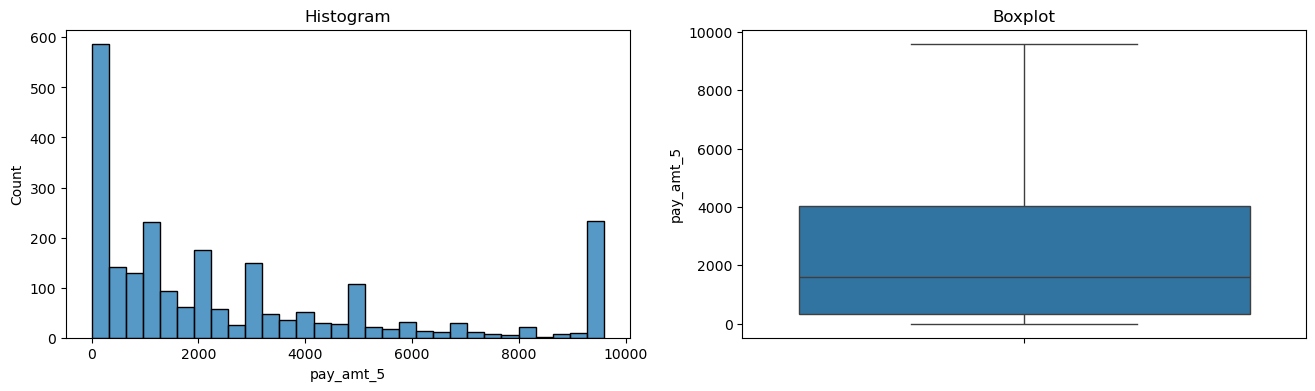

pay_amt_6 - Before Capping


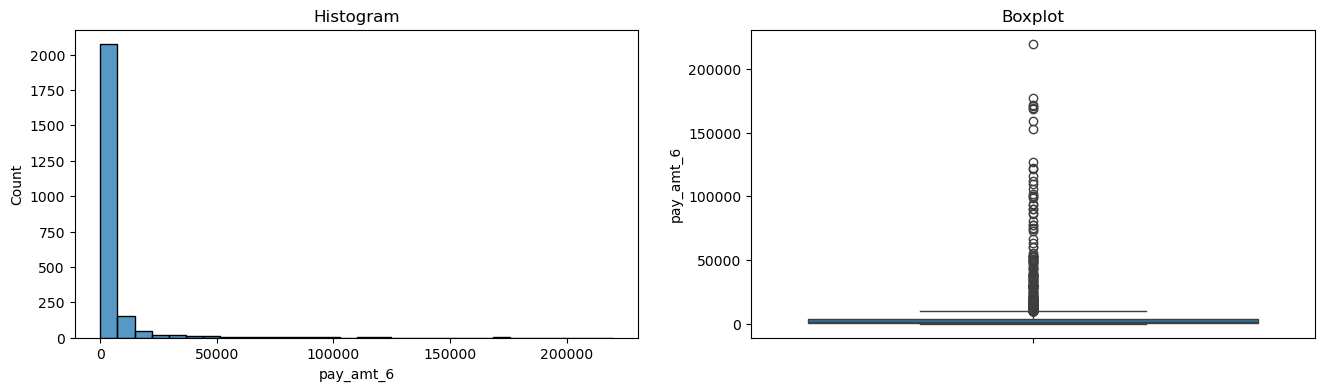


pay_amt_6 - After Capping


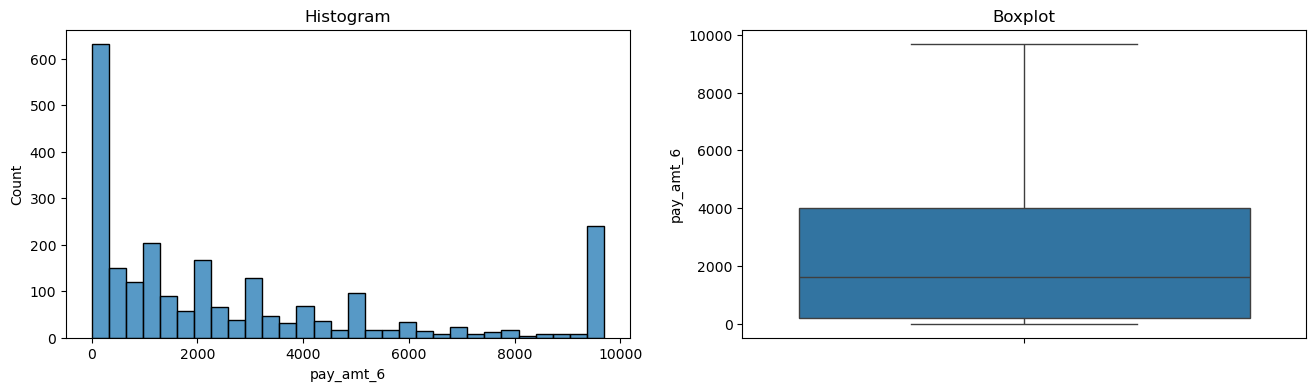

In [119]:
#looping sesuai kolom yang ada
for col in X_train:
    print(f'{col} - Before Capping')
    diagnostic_plots(X_train, col)

    print(f'\n{col} - After Capping')
    diagnostic_plots(X_train_capped, col)


- -----

##### **Missing Value Handling**

In [120]:
#Mengetahui jumlah data yang memiliki nilai NaN
nan_price_df = data_feature[data_feature['default_payment_next_month'].isna()]

# Group by 'name' and 'cab_type' and count NaN values
nan_price_grouped = nan_price_df.groupby(['age', 'marital_status']).size().reset_index(name='count')
nan_price_grouped

,age,marital_status,count


- ----

##### **Feature Selection**

In [121]:
ordinal_cols = data_feature[['education_level', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']]
nominal_cols = data_feature[['sex', 'marital_status']]
numerical_cols = data_feature[['limit_balance', 'age', 'bill_amt_1', 'bill_amt_2', 'bill_amt_3', 'bill_amt_4', 'bill_amt_5', 'bill_amt_6', 'pay_amt_1', 'pay_amt_2',
                  'pay_amt_3', 'pay_amt_4', 'pay_amt_5', 'pay_amt_6']]

In [122]:
# level confidence
alpha = 0.1

# Melakukan uji kendalltau untuk kolom ordinal
correlation_df_categorical = pd.DataFrame(columns=['cat_columns', 'tau-statistic', 'p-value', 'is_correlated'])

for cat_column in ordinal_cols.columns:
    # Mengubah kategori ke dalam angka berurut
    cat_column_num = X_train_capped[cat_column].astype('category').cat.codes
    y_train_num = y_train.astype('category').cat.codes
    
    tau, p = kendalltau(cat_column_num, y_train_num)
    
    is_correlated = 'Yes' if p < alpha else 'No'
    
    correlation_df_categorical = pd.concat([
        correlation_df_categorical,
        pd.DataFrame({'cat_columns': [cat_column], 'tau-statistic': [tau], 'p-value': [p], 'is_correlated': [is_correlated]})
    ], ignore_index=True)

correlation_df_categorical

/var/folders/pp/_scpqyy522j_3nxrlhdyg0wr0000gp/T/ipykernel_14243/2214532844.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  correlation_df_categorical = pd.concat([


,cat_columns,tau-statistic,p-value,is_correlated
0,education_level,0.060130,2.027747e-03,Yes
1,pay_0,0.282912,1.405205e-50,Yes
2,pay_2,0.217231,6.722697e-30,Yes
3,pay_3,0.200060,1.919670e-25,Yes
4,pay_4,0.200411,1.834855e-25,Yes
5,pay_5,0.198850,5.108636e-25,Yes
6,pay_6,0.180287,5.386462e-21,Yes


In [123]:
# level confidence
alpha = 0.1

# Melakukan uji kendalltau untuk kolom ordinal
correlation_df_categorical = pd.DataFrame(columns=['cat_columns', 'chi2-statistic', 'p-value', 'is_correlated'])

for cat_column in nominal_cols.columns:
    # Mengubah kategori ke dalam angka berurut
    cat_column_num = X_train_capped[cat_column].astype('category').cat.codes
    y_train_num = y_train.astype('category').cat.codes
    
    tau, p = kendalltau(cat_column_num, y_train_num)
    
    is_correlated = 'Yes' if p < alpha else 'No'
    
    correlation_df_categorical = pd.concat([
        correlation_df_categorical,
        pd.DataFrame({'cat_columns': [cat_column], 'tau-statistic': [tau], 'p-value': [p], 'is_correlated': [is_correlated]})
    ], ignore_index=True)

correlation_df_categorical

/var/folders/pp/_scpqyy522j_3nxrlhdyg0wr0000gp/T/ipykernel_14243/1496214706.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  correlation_df_categorical = pd.concat([


,cat_columns,chi2-statistic,p-value,is_correlated,tau-statistic
0,sex,NaN,0.348649,No,-0.019247
1,marital_status,NaN,0.194796,No,-0.026450


In [124]:
# level confidences
alpha = 0.1

# Melakukan uji spearmanr untuk setiap kolom numerical
correlation_df_num = pd.DataFrame(columns=['num_columns', 'spearmanr-statistic', 'p-value', 'is_correlated'])

for cont_column in numerical_cols.columns:
    corr, p = spearmanr(X_train_capped[cont_column], y_train)
    
    is_correlated = 'Yes' if p < alpha else 'No'
    
    correlation_df_num = pd.concat([
        correlation_df_num,
        pd.DataFrame({'num_columns': [cont_column], 'spearmanr-statistic': [corr], 'p-value': [p], 'is_correlated': [is_correlated]})
    ], ignore_index=True)

correlation_df_num

/var/folders/pp/_scpqyy522j_3nxrlhdyg0wr0000gp/T/ipykernel_14243/603789616.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  correlation_df_num = pd.concat([


,num_columns,spearmanr-statistic,p-value,is_correlated
0,limit_balance,-0.177566,2.964777e-18,Yes
1,age,0.006582,7.486751e-01,No
2,bill_amt_1,-0.005488,7.893511e-01,No
3,bill_amt_2,0.006962,7.346920e-01,No
4,bill_amt_3,0.013814,5.012881e-01,No
5,bill_amt_4,0.019885,3.330262e-01,No
6,bill_amt_5,0.023196,2.587848e-01,No
7,bill_amt_6,0.032247,1.163928e-01,No
8,pay_amt_1,-0.144874,1.345636e-12,Yes
9,pay_amt_2,-0.134332,5.074117e-11,Yes


Melalui uji korelasi kita mendapatkan bahwa terdapat 14 kolom yang akan digunakan untuk model testing.

- --

##### **Scaling**

In [125]:
numerical = ['limit_balance', 'pay_amt_1', 'pay_amt_2',
                  'pay_amt_3', 'pay_amt_4', 'pay_amt_5', 'pay_amt_6']
ordinal = ['education_level', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']
# nominal = ['sex', 'marital_status']
# Define pipelines
num_pipeline = make_pipeline(MinMaxScaler())
num_pipeline.fit(X_train_capped[numerical])
cat_pipeline = make_pipeline(OrdinalEncoder())
cat_pipeline.fit(X_train_capped[ordinal])

# ColumnTransformer
preprocessing_pipeline = ColumnTransformer([
    ('pipe_num', num_pipeline, numerical),
    ('pipe_cat', 'passthrough', ordinal)  # Use cat_pipeline here
])


In [126]:
# Transform training data
data_final_train = preprocessing_pipeline.fit_transform(X_train_capped)

# Transform testing data (using already fitted preprocessing_pipeline)
data_final_test = preprocessing_pipeline.transform(X_test_capped)

X_train_final = pd.DataFrame(data_final_train, columns=numerical + ordinal)
X_test_final = pd.DataFrame(data_final_test, columns=numerical + ordinal)

Disini, MinMaxScaler digunakan karena scaler ini memiliki ketahanan terhadap data yang skewed dimana dataset yang digunakan memiliki skewness.

##### **Model Definition**

Pada proyek ini, terdapat tiga macam model yang akan digunakan dalam menentukan prediksi terhadap default_payment_next_month. Ketiga model tersebut di antaranya adalah:
- SVM (Support Vector Machine)
- KNeighborsClassifier
- logistic Regession

In [127]:
# Full pipeline including classifier
clfsvc = make_pipeline(preprocessing_pipeline, SVC())
# Full pipeline including classifier
clfknc = make_pipeline(preprocessing_pipeline, KNeighborsClassifier())
# Full pipeline including classifier
clflog = make_pipeline(preprocessing_pipeline, LogisticRegression())

##### **Model Training**

In [230]:
# Assuming X_train and y_train are your training data
clfsvc.fit(X_train_final, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipe_num',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['limit_balance', 'pay_amt_1',
                                                   'pay_amt_2', 'pay_amt_3',
                                                   'pay_amt_4', 'pay_amt_5',
                                                   'pay_amt_6']),
                                                 ('pipe_cat', 'passthrough',
                                                  ['education_level', 'pay_0',
                                                   'pay_2', 'pay_3', 'pay_4',
                                                   'pay_5', 'pay_6'])])),
                ('svc', SVC())])

In [195]:
training_accuracy_svc = clfsvc.score(X_train_final, y_train)
y_pred_train_svc = clfsvc.predict(X_train_final)
print('Training CLassification Report: ', classification_report(y_pred_train_svc, y_train))
print('Training Confusion Matrix: ', confusion_matrix(y_pred_train_svc, y_train))
print('Training Accuracy: ', training_accuracy_svc)
print('Recall Score: ', recall_score(y_pred_train_svc, y_train))
print('Precision Score: ', precision_score(y_pred_train_svc, y_train))

Training CLassification Report:                precision    recall  f1-score   support

           0       0.97      0.85      0.90      2118
           1       0.38      0.76      0.51       254

    accuracy                           0.84      2372
   macro avg       0.67      0.81      0.71      2372
weighted avg       0.90      0.84      0.86      2372

Training Confusion Matrix:  [[1800  318]
 [  60  194]]
Training Accuracy:  0.8406408094435076
Recall Score:  0.7637795275590551
Precision Score:  0.37890625


In [130]:
# Assuming X_train and y_train are your training data
clflog.fit(X_train_final, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipe_num',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['limit_balance', 'pay_amt_1',
                                                   'pay_amt_2', 'pay_amt_3',
                                                   'pay_amt_4', 'pay_amt_5',
                                                   'pay_amt_6']),
                                                 ('pipe_cat', 'passthrough',
                                                  ['education_level', 'pay_0',
                                                   'pay_2', 'pay_3', 'pay_4',
                                                   'pay_5', 'pay_6'])])),
                ('logisticregression', LogisticRegression())])

In [232]:
training_accuracy_logreg = clflog.score(X_train_final, y_train)
y_pred_train_logreg = clflog.predict(X_train_final)
print('Training CLassification Report: ', classification_report(y_pred_train_logreg, y_train))
print('Training Confusion Matrix: ', confusion_matrix(y_pred_train_logreg, y_train))
print('Training Accuracy: ', training_accuracy_logreg)
print('Recall Score: ', recall_score(y_pred_train_logreg, y_train))
print('Precision Score: ', precision_score(y_pred_train_logreg, y_train))

Training CLassification Report:                precision    recall  f1-score   support

           0       0.97      0.83      0.89      2183
           1       0.27      0.73      0.39       189

    accuracy                           0.82      2372
   macro avg       0.62      0.78      0.64      2372
weighted avg       0.92      0.82      0.85      2372

Training Confusion Matrix:  [[1809  374]
 [  51  138]]
Training Accuracy:  0.8208263069139966
Recall Score:  0.7301587301587301
Precision Score:  0.26953125


In [132]:
# Assuming X_train and y_train are your training data
clfknc.fit(X_train_final, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipe_num',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['limit_balance', 'pay_amt_1',
                                                   'pay_amt_2', 'pay_amt_3',
                                                   'pay_amt_4', 'pay_amt_5',
                                                   'pay_amt_6']),
                                                 ('pipe_cat', 'passthrough',
                                                  ['education_level', 'pay_0',
                                                   'pay_2', 'pay_3', 'pay_4',
                                                   'pay_5', 'pay_6'])])),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [197]:
training_accuracy_knc = clfknc.score(X_train_final, y_train)
y_pred_train_knc = clfknc.predict(X_train_final)
print('Training CLassification Report: ', classification_report(y_pred_train_knc, y_train))
print('Training Confusion Matrix: ', confusion_matrix(y_pred_train_knc, y_train))
print('Training Accuracy: ', training_accuracy_knc)
print('Recall Score: ', recall_score(y_pred_train_knc, y_train))
print('Precision Score: ', precision_score(y_pred_train_knc, y_train))

Training CLassification Report:                precision    recall  f1-score   support

           0       0.95      0.87      0.91      2041
           1       0.48      0.74      0.58       331

    accuracy                           0.85      2372
   macro avg       0.72      0.80      0.75      2372
weighted avg       0.89      0.85      0.86      2372

Training Confusion Matrix:  [[1774  267]
 [  86  245]]
Training Accuracy:  0.8511804384485666
Recall Score:  0.7401812688821753
Precision Score:  0.478515625


Berdasarkan model training yang telah dilakukan, didapatkan hasil akurasi training sebagai berikut:
- Training Accuracy SVC = 0.835 atau 83.5% dengan Recall Score = 0.7637 atau 76.37% dan Precision Score = 0.3789 atau 37.89%
- Training Accuracy Logistic Regreesion = 0.8107 atau 81.07% dengan Recall Score = 0.7301 atau 73.01% dan Precision Score = 0.2695 atau 26.95%
- Training Accuracy KNeighborClassifier = 0.8465 atau 84.65% dengan Recall Score = 0.7401 atau 74.01% dan Precision Score = 0.4785 atau 47.85%

Dari hasil training yang didapatkan, kita menggunakan K Neighbor Classifier dimana alasan dalam memilih model klasifikasi ini adalah karena memiliki nilai precision score sebesar 47.85%, dimana precision score akan digunakan sebagai scoring pada model evaluation nantinya untuk mencari seberapa akurat model dalam menentukan True Positive atau model tepat menentukan dari keseluruhan data yang True Positive atau benar-benar default seberapa akurat model mengatakan bahwa data tersebut benar-benar default.

Meskipun begitu, hyperparameter tuning akan dilakukan kepada ketiga model untuk mengetahui perbandingan hasil testing pada precision score dimana model manakah yang memiliki hasil testing dan training paling bagus dengan seminim mungkin menghindari overfitting. Nantinya model deployment akan menggunakan model dengan hasil precision score terbaik setelah model dihyperparameter tuning.

##### **Hyperparameter Tuning**

Pada bagian ini, ketiga model yang telah ditraining akan memasuki fase hyperparameter tuning. Parameter-parameter yang digunakan di antaranya adalah:
- SVC
    - svc__C: digunakan untuk melakukan balancing antara margin data train dan test yang terlalu besar serta missclasification yang rendah
    - svc__gamma: digunakan untuk menghandle data yang non-linear, dimana niai gamma tidak boleh terlalu tinggi untuk mencegah overfitting
    - svc__kernel: digunakan untuk melakukan transformasi data
- Logistic Regression
    - C
    - penalty
    - solver
- KNN
    - n-neighbors
    - weights
    - p / distance

In [198]:
#melakukan cek hyperparameter untuk svc dengan kernel linear

param_grid = {'svc__C': [0.001, 0.01, 0.1, 1, 2, 50],
              'svc__gamma': [0.001, 0.01, 0.1, 1, 2, 2.5],
              'svc__kernel': [ 'rbf', 'linear']
              }
grid_svc = RandomizedSearchCV(clfsvc, param_distributions=param_grid, cv=5, n_iter=50, random_state=42, n_jobs=-1, scoring='precision')
grid_svc.fit(X_train_final, y_train)

print('Best cross-validation accuracy : {:.2f}'.format(grid_svc.best_score_))
print('Best parameters : ', grid_svc.best_params_)
print('Test set accuracy : {:.2f}'.format(grid_svc.score(X_test_final, y_test)))

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_

Best cross-validation accuracy : 1.00
Best parameters :  {'svc__kernel': 'rbf', 'svc__gamma': 2.5, 'svc__C': 0.1}
Test set accuracy : 1.00


In [203]:
best_models_svc = grid_svc.best_estimator_
best_models_svc

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipe_num',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['limit_balance', 'pay_amt_1',
                                                   'pay_amt_2', 'pay_amt_3',
                                                   'pay_amt_4', 'pay_amt_5',
                                                   'pay_amt_6']),
                                                 ('pipe_cat', 'passthrough',
                                                  ['education_level', 'pay_0',
                                                   'pay_2', 'pay_3', 'pay_4',
                                                   'pay_5', 'pay_6'])])),
                ('svc', SVC(C=0.1, gamma=2.5))])

In [199]:
#melakukan cek hyperparameter untuk svc dengan kernel linear

param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 2, 10, 100],
              'logisticregression__penalty': ['l1', 'l2'],
              'logisticregression__solver': ['liblinear', 'saga']
              }
grid_logreg = RandomizedSearchCV(clflog, param_distributions=param_grid, cv=5, n_iter=50, random_state=42, n_jobs=-1, scoring='precision')
grid_logreg.fit(X_train_final, y_train)

print('Best cross-validation accuracy : {:.2f}'.format(grid_logreg.best_score_))
print('Best parameters : ', grid_logreg.best_params_)
print('Test set accuracy : {:.2f}'.format(grid_logreg.score(X_test_final, y_test)))

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 24 is smaller than n_iter=50. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined 

Best cross-validation accuracy : 0.88
Best parameters :  {'logisticregression__solver': 'saga', 'logisticregression__penalty': 'l2', 'logisticregression__C': 0.001}
Test set accuracy : 0.75


In [200]:
best_models_logreg = grid_logreg.best_estimator_
best_models_logreg

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipe_num',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['limit_balance', 'pay_amt_1',
                                                   'pay_amt_2', 'pay_amt_3',
                                                   'pay_amt_4', 'pay_amt_5',
                                                   'pay_amt_6']),
                                                 ('pipe_cat', 'passthrough',
                                                  ['education_level', 'pay_0',
                                                   'pay_2', 'pay_3', 'pay_4',
                                                   'pay_5', 'pay_6'])])),
                ('logisticregression',
                 LogisticRegression(C=0.001, solver='saga'))])

In [236]:
best_models_logreg_coef = grid_logreg.best_estimator_.named_steps['logisticregression']
print('Coefficient: ', best_models_logreg_coef.coef_)
print('Intercept: ', best_models_logreg_coef.intercept_)

Coefficient:  [[-0.02216355 -0.0347266  -0.03557691 -0.02820181 -0.03331254 -0.02384587
  -0.03260311  0.0161015   0.14391793  0.11932911  0.06919098  0.0709947
   0.06695339  0.09273759]]
Intercept:  [-1.20900055]


In [240]:
#melakukan cek hyperparameter untuk kneighbor classifier

param_grid = {
    'kneighborsclassifier__n_neighbors': range(1, 50),  # Number of neighbors to use
    'kneighborsclassifier__weights': ['uniform', 'distance'],  # Weight function used in prediction
    'kneighborsclassifier__p': [1, 2, 3]  # Power parameter for Minkowski distance (1 for Manhattan, 2 for Euclidean)
}
grid_knc = RandomizedSearchCV(clfknc, param_distributions=param_grid, cv=10, n_iter=60, random_state=84, n_jobs=-1, scoring='precision')
grid_knc.fit(X_train_final, y_train)

print('Best cross-validation accuracy : {:.2f}'.format(grid_knc.best_score_))
print('Best parameters : ', grid_knc.best_params_)
print('Test set accuracy : {:.2f}'.format(grid_knc.score(X_test_final, y_test)))

Best cross-validation accuracy : 0.71
Best parameters :  {'kneighborsclassifier__weights': 'uniform', 'kneighborsclassifier__p': 2, 'kneighborsclassifier__n_neighbors': 42}
Test set accuracy : 0.69


In [202]:
best_models_knc = grid_knc.best_estimator_
best_models_knc

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipe_num',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['limit_balance', 'pay_amt_1',
                                                   'pay_amt_2', 'pay_amt_3',
                                                   'pay_amt_4', 'pay_amt_5',
                                                   'pay_amt_6']),
                                                 ('pipe_cat', 'passthrough',
                                                  ['education_level', 'pay_0',
                                                   'pay_2', 'pay_3', 'pay_4',
                                                   'pay_5', 'pay_6'])])),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=42))])

Parameter K terbaik untuk KNN dapat dilakukan dengan melakukan tuning pada bagian weights, n-neighbors, dan distance parameter. Kemudian dilakukan RandomizedSearchCV dimana parameter dicari berdasarkan iterasi yang diberikan dan parameternya. Kemudian dari sana kita dapat menggunakan best_params_ dan best_estimator_ untuk mendapatkan K terbaik untuk model KNN kita.

- ---

Dari percobaan hyperparameter tuning yang telah dilakukan terhadap ketiga model terhadap scoring terhadap nilai precission kita mendapatkan hasil sebagai berikut:

- SVM mendapatkan akurasi sebesar 1.00 atau 100% (mengidikasikan kemungkinan overfitting).
- Logistic Regression mendapatkan akurasi sebesar 0.75 atau 75%.
- KNN mendapatkan akurasi sebesar 0.69 atau 69%

**Intercept dan Koefisien**

Selain itu kita mendapatkan nilai intercept dan koefisien dari Logistic Regression sebagai berikut:
- Koefisien: [-0.02216355 -0.0347266  -0.03557691 -0.02820181 -0.03331254 -0.02384587
  -0.03260311  0.0161015   0.14391793  0.11932911  0.06919098  0.0709947
   0.06695339  0.09273759]
- Intercept: [-1.20900055]

Nilai intersep yang didapatkan adalah -1.209, dimana ini menjadi dasar dari model logistic regression ketika semua parameter yang digunakan untuk menetapkan klasifikasi default atau tidak berada pada angka 0. Hal ini berarti bahwa tanpa adanya input yang dilakukan kepada parameter tersebut maka kita bisa asumsikan dengan positif adalah dia Default dan Negatif adalah Tidak Default maka kemungkinan untuk mendapatkan Default dengan parameter yang berjarak tipis dari titik awal maka kemungkinan untuk mendapatkan nilai Default rendah.

Sementara dari masing-masing koefisien melambangkan bagaimana tingkat korelasi atau relasi antara variabel yang menjadi parameter pada bagian column transformer dengan target dalam hal ini targetnya adalah Default Payment Next Month. Bisa dilihat dari 14 parameter, 7 di antaranya memiliki relasi negatif dimana hal ini bisa menjadi salah satu alasan kenapa data bukan termasuk Default (1). Sementara itu terdapat 7 parameter lainnya yang memiliki relasi positif dimana hal ini mengindikasikan data termasuk ke dalam Default (1).

Selanjutnya, dari masing-masing hyper parameter tuning yang telah didapatkan maka selanjutnya adalah melakukan evaluasi model untuk membandingkan masing-masing hasil akurasi dari setiap model.

- ---

##### **Model Evaluation**

Setelah melakukan model training dan hyperparameter tuning, selanjutnya model tersebut dievaluasi dengan mencari Precision, Recall, f1-score, dan accuracy.

Disini kita menggunakan Precision score karena ingin mengetahui seberapa banyak data yang diklasifikasi termasuk ke dalam True Positive.
Sementara untuk penggunaan dari metriks yang lain dijabarkan sebagai berikut:
- Recall: mencari seberapa banyak data yang benar-benar positif yang didapatkan oleh model adalah positif serta berusaha untuk menghindari nilai False Negative.
- F1 Score: mencari balance atau rata-rata dari precision dan recall.
- Accuracy: seberapa akurat model kita dalam melakukan proses klasifikasi.

Disini kita akan membandingkan hasil test accuracy dari based atau sebelum dilakukan hyperparameter tuning dan juga setelah dilakukan hyperparameter tuning.

**OVERALL**

Sebelum dan Sesudah hyperparameter tuning

In [244]:
# Check performance model

print('Sebelum Hyperparameter Tuning')
print('')

y_pred_train = clfsvc.predict(X_train_final)
y_pred_test = clfsvc.predict(X_test_final)

print('Train')
print(classification_report(y_train, y_pred_train))
training_accuracy_knc = clfsvc.score(X_train_final, y_train)
print('Training Accuracy: ', training_accuracy_knc)
print('')

print('Test')
print(classification_report(y_test, y_pred_test))

y_pred_test = clfsvc.score(X_test_final, y_test)
print ('Testing Accuracy: ', y_pred_test)

Sebelum Hyperparameter Tuning

Train
              precision    recall  f1-score   support

           0       0.85      0.97      0.90      1860
           1       0.76      0.38      0.51       512

    accuracy                           0.84      2372
   macro avg       0.81      0.67      0.71      2372
weighted avg       0.83      0.84      0.82      2372

Training Accuracy:  0.8406408094435076

Test
              precision    recall  f1-score   support

           0       0.87      0.95      0.91       470
           1       0.70      0.44      0.54       123

    accuracy                           0.84       593
   macro avg       0.78      0.70      0.72       593
weighted avg       0.83      0.84      0.83       593

Testing Accuracy:  0.8448566610455311


Sesudah Hyperparameter Tuning

Training Accuracy After Hyperparameter Tuning: 0.79
Train
              precision    recall  f1-score   support

           0       0.79      1.00      0.88      1860
           1       1.00      0.04      0.07       512

    accuracy                           0.79      2372
   macro avg       0.90      0.52      0.48      2372
weighted avg       0.84      0.79      0.71      2372


Testing Accuracy After Hyperparameter Tuning: 0.80

Test
              precision    recall  f1-score   support

           0       0.80      1.00      0.89       470
           1       1.00      0.06      0.11       123

    accuracy                           0.80       593
   macro avg       0.90      0.53      0.50       593
weighted avg       0.84      0.80      0.73       593


Confusion Matrix data Testing


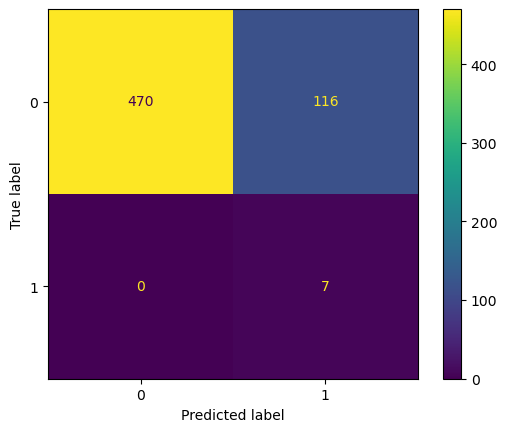

In [245]:
# Check performance model

print('Sesudah Hyperparameter Tuning')
print('')

y_pred_train_tuned = grid_svc.best_estimator_.score(X_train_final, y_train)

# y_pred_train_predict_tuned = grid_knc.best_estimator_.predict(X_train_capped)
y_pred_train_predict_tuned = best_models_svc.predict(X_train_final)
print('Training Accuracy After Hyperparameter Tuning: {:.2f}'.format(y_pred_train_tuned))

print('Train')
print(classification_report(y_train, y_pred_train_predict_tuned))
print('')

y_pred_test_tuned = grid_svc.best_estimator_.score(X_test_final, y_test)
y_pred_test_predict_tuned = grid_svc.best_estimator_.predict(X_test_final)
print('Testing Accuracy After Hyperparameter Tuning: {:.2f}'.format(y_pred_test_tuned))
print('')

print('Test')
print(classification_report(y_test, y_pred_test_predict_tuned))
print('')
print('Confusion Matrix data Testing')
cm = confusion_matrix(y_pred_test_predict_tuned, y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clfsvc.classes_)
disp.plot()

In [243]:
# Check performance model

print('Sebelum Hyperparameter Tuning')
print('')

y_pred_train = clflog.predict(X_train_final)
y_pred_test = clflog.predict(X_test_final)

print('Train')
print(classification_report(y_train, y_pred_train))
training_accuracy_knc = clflog.score(X_train_final, y_train)
print('Training Accuracy: ', training_accuracy_knc)
print('')

print('Test')
print(classification_report(y_test, y_pred_test))

y_pred_test = clflog.score(X_test_final, y_test)
print ('Testing Accuracy: ', y_pred_test)

Sebelum Hyperparameter Tuning

Train
              precision    recall  f1-score   support

           0       0.83      0.97      0.89      1860
           1       0.73      0.27      0.39       512

    accuracy                           0.82      2372
   macro avg       0.78      0.62      0.64      2372
weighted avg       0.81      0.82      0.79      2372

Training Accuracy:  0.8208263069139966

Test
              precision    recall  f1-score   support

           0       0.84      0.97      0.90       470
           1       0.68      0.28      0.39       123

    accuracy                           0.82       593
   macro avg       0.76      0.62      0.64       593
weighted avg       0.80      0.82      0.79       593

Testing Accuracy:  0.8229342327150084


Sesudah Hyperparameter Tuning

Training Accuracy After Hyperparameter Tuning: 0.79
Train
              precision    recall  f1-score   support

           0       0.79      1.00      0.88      1860
           1       0.77      0.02      0.04       512

    accuracy                           0.79      2372
   macro avg       0.78      0.51      0.46      2372
weighted avg       0.78      0.79      0.70      2372


Testing Accuracy After Hyperparameter Tuning: 0.80

Test
              precision    recall  f1-score   support

           0       0.80      1.00      0.89       470
           1       0.75      0.02      0.05       123

    accuracy                           0.80       593
   macro avg       0.77      0.51      0.47       593
weighted avg       0.79      0.80      0.71       593


Confusion Matrix data Testing


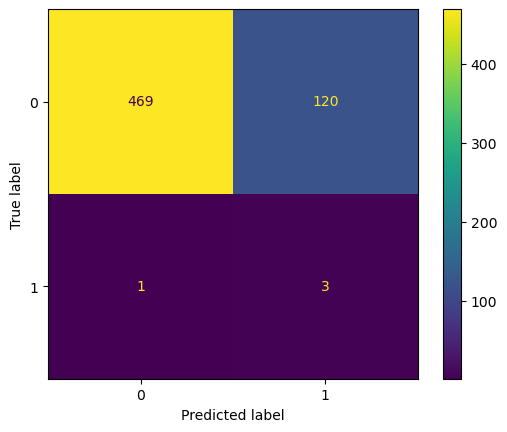

In [242]:
# Check performance model

print('Sesudah Hyperparameter Tuning')
print('')

y_pred_train_tuned = grid_logreg.best_estimator_.score(X_train_final, y_train)

# y_pred_train_predict_tuned = grid_knc.best_estimator_.predict(X_train_capped)
y_pred_train_predict_tuned = best_models_logreg.predict(X_train_final)
print('Training Accuracy After Hyperparameter Tuning: {:.2f}'.format(y_pred_train_tuned))

print('Train')
print(classification_report(y_train, y_pred_train_predict_tuned))
print('')

y_pred_test_tuned = grid_logreg.best_estimator_.score(X_test_final, y_test)
y_pred_test_predict_tuned = grid_logreg.best_estimator_.predict(X_test_final)
print('Testing Accuracy After Hyperparameter Tuning: {:.2f}'.format(y_pred_test_tuned))
print('')

print('Test')
print(classification_report(y_test, y_pred_test_predict_tuned))
print('')
print('Confusion Matrix data Testing')
cm = confusion_matrix(y_pred_test_predict_tuned, y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clflog.classes_)
disp.plot()

In [207]:
# Check performance model

print('Sebelum Hyperparameter Tuning')
print('')

y_pred_train = clfknc.predict(X_train_final)
y_pred_test = clfknc.predict(X_test_final)

print('Train')
print(classification_report(y_train, y_pred_train))
training_accuracy_knc = clfknc.score(X_train_final, y_train)
print('Training Accuracy: ', training_accuracy_knc)
print('')

print('Test')
print(classification_report(y_test, y_pred_test))

y_pred_test = clfknc.score(X_test_final, y_test)
print ('Testing Accuracy: ', y_pred_test)

Sebelum Hyperparameter Tuning

Train
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      1860
           1       0.74      0.48      0.58       512

    accuracy                           0.85      2372
   macro avg       0.80      0.72      0.75      2372
weighted avg       0.84      0.85      0.84      2372

Training Accuracy:  0.8511804384485666

Test
              precision    recall  f1-score   support

           0       0.86      0.92      0.89       470
           1       0.60      0.44      0.51       123

    accuracy                           0.82       593
   macro avg       0.73      0.68      0.70       593
weighted avg       0.81      0.82      0.81       593

Testing Accuracy:  0.8229342327150084


Sesudah Hyperparameter Tuning

Training Accuracy After Hyperparameter Tuning: 0.83
Train
              precision    recall  f1-score   support

           0       0.84      0.96      0.90      1860
           1       0.72      0.33      0.45       512

    accuracy                           0.83      2372
   macro avg       0.78      0.65      0.67      2372
weighted avg       0.81      0.83      0.80      2372


Testing Accuracy After Hyperparameter Tuning: 0.84

Test
              precision    recall  f1-score   support

           0       0.86      0.96      0.90       470
           1       0.69      0.38      0.49       123

    accuracy                           0.84       593
   macro avg       0.77      0.67      0.70       593
weighted avg       0.82      0.84      0.82       593


Confusion Matrix data Testing


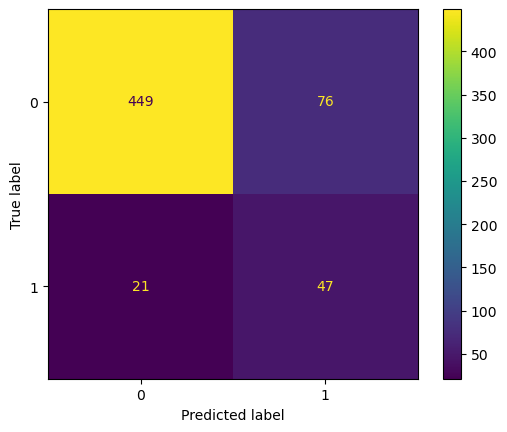

In [211]:
# Check performance model

print('Sesudah Hyperparameter Tuning')
print('')

y_pred_train_tuned = grid_knc.best_estimator_.score(X_train_final, y_train)

# y_pred_train_predict_tuned = grid_knc.best_estimator_.predict(X_train_capped)
y_pred_train_predict_tuned = best_models_knc.predict(X_train_final)
print('Training Accuracy After Hyperparameter Tuning: {:.2f}'.format(y_pred_train_tuned))

print('Train')
print(classification_report(y_train, y_pred_train_predict_tuned))
print('')

y_pred_test_tuned = grid_knc.best_estimator_.score(X_test_final, y_test)
y_pred_test_predict_tuned = grid_knc.best_estimator_.predict(X_test_final)
print('Testing Accuracy After Hyperparameter Tuning: {:.2f}'.format(y_pred_test_tuned))
print('')

print('Test')
print(classification_report(y_test, y_pred_test_predict_tuned))
print('')
print('Confusion Matrix data Testing')
cm = confusion_matrix(y_pred_test_predict_tuned, y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clfknc.classes_)
disp.plot()

Berdasarkan uji test dan training yang dilakukan pada dataset dimana dilakukan perbandingan hasil akurasi antara model ketika sebelum dilakukan proses perhitungan hyper parameter dan sesudah dilakukan perhitungan hyperparameter dimana didapatkan akurasi model:

Model yang digunakan: Logistic Regression

Berdasarkan: Precision Score

| Nama Model | Prediksi |Sebelum / Sesudah |Training | Test |
| ---------- | -------- |----------------- |-------- | ---- |
| K Neighbor Classifier | 0 | Sebelum | 83% | 84% |
|                       | 1 | Sebelum | 73% | 68% |
|                       | 0 | Sesudah | 79% | 80% |
|                       | 1 | Sesudah | 77% | 75% |


Bila diperhatikan, precision score yang didapatkan mengalami penurunan akurasi setelah dilakukan hyperparameter tuning jika dibandingkan dengan model based atau sebelum dilakukan tuning. Tetapi untuk nilai Default mengalami peningkatan akurasi yang cukup bisa diterima.

Selain itu, berdasarkan confusion matrix yang dibuat, kita mendapatkan bahwa terdapat 469 data yang merupakan True Positive (TP), 120 data yang bersifat False Positive (FP), 1 data yang bersifat False Negative (FN), dan 3 data yang bersifat True Negative (TN).

- ---

##### **Model Saving**

In [220]:
with open('list_num_cols.txt', 'w') as file_1:
  json.dump(numerical, file_1)

with open('list_ordinal_cols.txt', 'w') as file_2:
  json.dump(ordinal, file_2)

with open('best_models_knc.pkl', 'wb') as file_3:
  pickle.dump(best_models_knc, file_3)

with open('scaler.pkl', 'wb') as file_4:
  pickle.dump(num_pipeline, file_4)

with open('encoder.pkl', 'wb') as file_5:
  pickle.dump(cat_pipeline, file_5)

with open('best_models_svc.pkl', 'wb') as file_6:
  pickle.dump(best_models_svc, file_6)

with open('best_models_logreg.pkl', 'wb') as file_7:
  pickle.dump(best_models_logreg, file_7)

- ---

#### **Kesimpulan**

Berdasarkan EDA dan uji klasifikasi yang telah dilakukan dengan menggunakan model SVM, Logistic Regression, dan K Neighbor Classifier didapatkan beberapa hal sebagai berikut:
- Kelompok Usia yang paling banyak menggunakan kartu kredit berada pada kisaran mid-20s hingga mid-30s. Hal ini juga berkorelasi dengan total limit balance dimana konsumen dengan usia lebih dari 40 tahun memiliki limit balance yang cukup rendah.
- Level Pendidikan Graduate School dan University memiliki limit balance paling tinggi sehingga bisa diasumsikan mereka tidak default dimana credit score mereka bagus dan kartu kredit mereka cukup sering digunakan.
- Dikarenakan data yang imbalance, maka model rentan terhadap overfitting dan juga dapat mengganggu hasil prediksi dan klasifikasi. Dimana data pada 0 atau tidak default lebih tinggi daripada data 1 atau Default
- Dengan nilai intersep yang berada pada -1.209 maka indikasi bahwa data yang ditraining di kemudian lebih memungkinkan untuk masuk ke dalam Tidak Default daripada Default.
- Berdasarkan model evaluasi dan model training yang dilakukan, maka kita mendapatkan bahwa logistic regression memiliki hasil precision score yang lebih baik daripada model lainnya dimana walaupun overfitting karena imbalance dataset tetapi masih dalam batas yang lebih baik daripada SVM dan KNN.